In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
from scipy.sparse import csr_matrix, save_npz, load_npz
import dask.dataframe as dd
import gc

def batch_cosine_similarity(dtm, batch_size=1000):
    num_rows = dtm.shape[0]
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        yield cosine_similarity(dtm[start:end], dtm)

import psutil
def print_ram_usage(step = 0):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"[{step}] RAM Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

# # Load data (assuming data is in a CSV file, replace 'data.csv' with your actual file path)
# data = pd.read_csv('../int_data/Input_patent_matrix.csv')
data = pd.read_csv('../int_data/Input_patent_matrix_US.csv')
data

/users/xiet13/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,i,recid,occhisco,description,street,city,county,state,region,full_address,names,pos2,max
0,US100001A,[1119227.0],[54010.0],FOLLOWING EXACT DESCRIPTION ENABLE SKILLED ART...,[],['Livingston'],['Sumter'],['Alabama'],[],"['Livingston, Sumter, Alabama']","JOSEPH ARRINGTON, N. PETERS",496,6202
1,US100007A,[38084797.0],[83850.0],UNITED WILLIAM PATENT IMPROVEMENT SCHEDULE MAK...,[],['Altoona'],['Blair'],['Pennsylvania'],[],"['Altoona, Blair, Pennsylvania']","N. PETERS, WILLIAM A. BOYDEN, CHARLES J. MANN",1,2746
2,US100024A,[40470809.0],[87340.0],STOVE UNITED PATENT GEORGE FEBRUARY SCHEDULE M...,[],['Philadelphia'],[],['Pennsylvania'],[],"['Philadelphia, Pennsylvania']",GEORGE FROH,-1,3885
3,US100037A,[6771858.0],[83400.0],TILL UNITED J STENT ASSIGNOR PATENT ELATED FEB...,[],['Chicago'],['Cook'],['Illinois'],[],"['Chicago, Cook, Illinois']",AUSTIN D. HOFFMAN,1,3889
4,US100041A,[14941022.0],[99999.0],FOLLOWING DESCRIPTION ENABLE SKILLED ART USE D...,[],['Maysville'],['Mason'],['Kentucky'],['East South Central Division'],"['Maysville, Kentucky']","N. PETERS, JAMES JACOBS",445,3221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42941,US99984A,[28434939.0],[39310.0],UNITED PATENT JOHN NEW FEBRUARY SCHEDULE MAKIN...,[],['Buffalo'],['Erie'],['New York'],[],"['Buffalo, NY']","N. PETERS, JOHN V. WACKERMAN",-1,3374
42942,US99985A,[31600299.0],[75600.0],WEST NEW PATENT FEBRUARY IMPROVEMENT SCHEDULE ...,[],['West Troy'],['Albany'],['New York'],[],"['West Troy, Albany, New York']","FRIEDRICH WEGNER, CHARLES SCHLEETER",1,5832
42943,US99987A,[29132340.0],[79920.0],FOLLOWING EXACT DESCRIPTION ENABLE SKILLED ART...,[],['Brooklyn'],['Kings'],['New York'],[],"['Brooklyn, Kings County, New York']","ROBERT WENT, N. PETERS",484,3011
42944,US99991A,[46549109.0],[81300.0],FOLLOWING EXACT DESCRIPTION MARKED PART NATURE...,[],['Londonderry'],['Windham'],['Vermont'],[],"['Londonderry, Windham, Vermont']",SILAS WHITMAN,500,1808


In [3]:
# TODO: readme

In [4]:
# data.i.nunique(), data.description.nunique(), data.recid.nunique(), data[['recid', 'i']].set_index(['recid', 'i']).index.is_unique, len(data[['recid', 'i']].set_index(['recid', 'i']))
# unique 22,144 patent-inventor pairs

data.i.nunique(), data.description.nunique()

(42946, 42946)

In [2]:
# Count the number of words in the 'description' column
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data

,i,recid,occhisco,description,street,city,county,state,region,full_address,names,pos2,max,strcount
0,US100001A,[1119227.0],[54010.0],FOLLOWING EXACT DESCRIPTION ENABLE SKILLED ART...,[],['Livingston'],['Sumter'],['Alabama'],[],"['Livingston, Sumter, Alabama']","JOSEPH ARRINGTON, N. PETERS",496,6202,147
1,US100007A,[38084797.0],[83850.0],UNITED WILLIAM PATENT IMPROVEMENT SCHEDULE MAK...,[],['Altoona'],['Blair'],['Pennsylvania'],[],"['Altoona, Blair, Pennsylvania']","N. PETERS, WILLIAM A. BOYDEN, CHARLES J. MANN",1,2746,78
2,US100024A,[40470809.0],[87340.0],STOVE UNITED PATENT GEORGE FEBRUARY SCHEDULE M...,[],['Philadelphia'],[],['Pennsylvania'],[],"['Philadelphia, Pennsylvania']",GEORGE FROH,-1,3885,137
3,US100037A,[6771858.0],[83400.0],TILL UNITED J STENT ASSIGNOR PATENT ELATED FEB...,[],['Chicago'],['Cook'],['Illinois'],[],"['Chicago, Cook, Illinois']",AUSTIN D. HOFFMAN,1,3889,122
4,US100041A,[14941022.0],[99999.0],FOLLOWING DESCRIPTION ENABLE SKILLED ART USE D...,[],['Maysville'],['Mason'],['Kentucky'],['East South Central Division'],"['Maysville, Kentucky']","N. PETERS, JAMES JACOBS",445,3221,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42888,US99984A,[28434939.0],[39310.0],UNITED PATENT JOHN NEW FEBRUARY SCHEDULE MAKIN...,[],['Buffalo'],['Erie'],['New York'],[],"['Buffalo, NY']","N. PETERS, JOHN V. WACKERMAN",-1,3374,98
42889,US99985A,[31600299.0],[75600.0],WEST NEW PATENT FEBRUARY IMPROVEMENT SCHEDULE ...,[],['West Troy'],['Albany'],['New York'],[],"['West Troy, Albany, New York']","FRIEDRICH WEGNER, CHARLES SCHLEETER",1,5832,127
42890,US99987A,[29132340.0],[79920.0],FOLLOWING EXACT DESCRIPTION ENABLE SKILLED ART...,[],['Brooklyn'],['Kings'],['New York'],[],"['Brooklyn, Kings County, New York']","ROBERT WENT, N. PETERS",484,3011,73
42891,US99991A,[46549109.0],[81300.0],FOLLOWING EXACT DESCRIPTION MARKED PART NATURE...,[],['Londonderry'],['Windham'],['Vermont'],[],"['Londonderry, Windham, Vermont']",SILAS WHITMAN,500,1808,41


In [3]:
data['description_len'] = data.description.apply(len)
data['description_len'].value_counts(), data['description_len'].isna().sum()

(description_len
 691     77
 690     74
 593     70
 607     69
 703     68
         ..
 2481     1
 2233     1
 2361     1
 2684     1
 3473     1
 Name: count, Length: 2631, dtype: int64,
 0)

- All description are present and longer than 0

In [7]:
# data.i.nunique(), data.description.nunique(), data.recid.nunique(), data[['recid', 'i']].set_index(['recid', 'i']).index.is_unique, len(data[['recid', 'i']].set_index(['recid', 'i']))
# unique 22,120 patent-inventor pairs

data.i.nunique(), data.description.nunique() # Two patents share the same description

(42893, 42893)

In [8]:
data.description.value_counts() # the first is a duplication

description
REVOLVING FIRE UNITED PATENT FREEMAN FORMING PART DECEMBER ORIGINAL ELATED JULY APPLICATION REISSUE OCTOBER B MAY KNOWN NEW USEFUL IMPROVEMENT REVOLVER FOLLOWING TOP BOTTOM IO PISTOL PROVIDED ROTARY DRAWN LATERALLY VERTICAL LONGITUDINAL SECTION SHOWING CHARGE MAGAZINE WITHIN CHAMBER SPACE RECEPTION BLOCK UPON SWINGING NEAR FRONT JOINTED BARREL JOINT PIN PIVOT SEEN ARM SHOWN SUFFICIENT LENGTH ADMIT SLIDE NECESSARY DISTANCE LENGTHWISE RECESS STOCK ESPECIALLY SIDE VIEW WITHOUT ADVANCE FORMED PARTICULARLY REAR ELEVATION SUITABLE RECEIVE BORE CORRESPONDING DIAMETER CONTINUATION NEXT FACE BEVELED CORRESPOND OPERATE ABUTMENT CONSTITUTE PRESS BACK ACT CATCHING LATTER INNERMOST HOLD PLACE RELATIVELY PIECE E OCCASION FORWARD SPINDLE MOVEMENT PREVENT INWARD ACTION FORCED REARMOST POSITION SAID RETRACTOR G DISK CIRCULAR FIT LITTLE GREATER CONNECTED TWO PROJECTING ENTER FREELY KEPT CONNECTION SCREWED BEYOND BODY STOP TAKING THUMB APPLIED OPPOSITE EXTRACT CARTRIDGE TIME CLAIM MADE MANNER

In [9]:
# Create a document-term matrix
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(data['description'])

# Save the DTM as a sparse matrix to avoid memory issues
# save_npz('../int_data/dtm.npz', dtm)
save_npz('../int_data/US_proxy/dtm.npz', dtm)

In [3]:
# dtm = load_npz('../int_data/dtm.npz')
dtm = load_npz('../int_data/US_proxy/dtm.npz') # Shape of dtm: (number of documents, size of the vocabulary)
dtm

<42893x20002 sparse matrix of type '<class 'numpy.int64'>'
	with 5573359 stored elements in Compressed Sparse Row format>

In [ ]:
# import numpy as np
# from sklearn.preprocessing import normalize
# from scipy.sparse import csr_matrix

# # Normalize rows of the sparse matrix (L2 normalization)
# dtm_normalized_sparse = normalize(dtm, axis=1, norm='l2')

# # Convert normalized sparse matrix to dense format
# dtm_normalized = dtm_normalized_sparse.toarray()

# # Memory-map the cosine similarity matrix to disk
# n_rows = dtm_normalized.shape[0]
# cosine_sim_matrix = np.memmap("cosine_sim_matrix.dat", dtype="float32", mode="w+", shape=(n_rows, n_rows))

# # Compute cosine similarity in one global operation
# cosine_sim_matrix[:, :] = np.dot(dtm_normalized, dtm_normalized.T)

# # Flush to disk and release memory-mapped object
# cosine_sim_matrix.flush()


In [ ]:
# from sklearn.preprocessing import normalize
# from scipy.sparse import csr_matrix

# # cosine_similarity(A,B)= ||A||⋅||B|| / (A⋅B)
# # 
# # Assume dtm is your sparse document-term matrix (csr_matrix)
# # Normalize rows of the matrix to have unit length (L2 normalization)
# dtm_normalized = normalize(dtm, axis=1, norm='l2')

# # # Compute cosine similarity matrix as the dot product of the normalized matrix
# # cosine_sim_matrix = dtm_normalized @ dtm_normalized.T

# # Compute using Numpy
# dtm_dense = dtm.toarray()
# cosine_sim_matrix = np.dot(dtm_normalized, dtm_normalized.T)

In [ ]:
# 3h
# import numpy as np
# from scipy.sparse import csr_matrix
# from sklearn.metrics.pairwise import cosine_similarity
# from joblib import Parallel, delayed
# from tqdm import tqdm

# # Assume dtm is your sparse document-term matrix (e.g., csr_matrix)
# n_rows = dtm.shape[0]

# # Function to compute cosine similarity for a single row
# def compute_row_cosine_similarity(row_idx, dtm):
#     return cosine_similarity(dtm[row_idx], dtm, dense_output=False).toarray()[0]

# # Parallel computation with a progress bar
# results = Parallel(n_jobs=128, prefer="threads")(
#     delayed(compute_row_cosine_similarity)(i, dtm) for i in tqdm(range(n_rows), desc="Computing cosine similarity")
# )

# # Combine results into a sparse matrix
# cosine_sim_matrix = csr_matrix(results)

In [ ]:
# # 20 min, resulted matrix (dense) 267 GB
# import numpy as np
# from sklearn.preprocessing import normalize
# from scipy.sparse import csr_matrix
# import joblib
# from tqdm import tqdm

# # Save the sparse matrix to disk using joblib for memory-mapping
# dtm_mmap_path = "../tmp/dtm_mmap.pkl"
# joblib.dump(dtm, dtm_mmap_path)
# dtm = joblib.load(dtm_mmap_path)

# # Normalize the sparse matrix row-wise
# normalized_dtm = normalize(dtm, norm='l2', axis=1)

# # Output path for the cosine similarity matrix
# cosine_sim_path = "../int_data/US_proxy/cosine_sim_matrix.pkl"

# # Define chunk size
# chunk_size = 1000
# n_rows = dtm.shape[0]

# # Memory-map the output file
# with open(cosine_sim_path, 'wb') as f:
#     # Process in chunks with a progress bar
#     for i in tqdm(range(0, n_rows, chunk_size), desc="Processing cosine similarity"):
#         # Compute the dot product for the chunk
#         chunk_result = normalized_dtm[i:i + chunk_size].dot(normalized_dtm.T)
#         # chunk_sparse = csr_matrix(chunk_result)
#         # Save the chunk to disk incrementally
#         joblib.dump(chunk_result, f)


In [11]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix, save_npz
import joblib
from tqdm import tqdm
import os

# Save the sparse matrix to disk using joblib for memory-mapping
dtm_mmap_path = "../tmp/dtm_mmap.pkl"
joblib.dump(dtm, dtm_mmap_path)
dtm = joblib.load(dtm_mmap_path)

# Normalize the sparse matrix row-wise
normalized_dtm = normalize(dtm, norm='l2', axis=1)

# Output directory for storing chunks
output_dir = "../int_data/US_proxy/sparse_chunks"
os.makedirs(output_dir, exist_ok = True)
chunk_size = 10000
n_rows = dtm.shape[0]

# Process in chunks and save each chunk as a sparse matrix
for i in tqdm(range(0, n_rows, chunk_size), desc="Processing cosine similarity"):
    # Compute the dot product for the current chunk
    chunk_result = normalized_dtm[i:i + chunk_size].dot(normalized_dtm.T)
    print("dot complete")
    
    # Convert the chunk to a sparse matrix
    chunk_sparse = csr_matrix(chunk_result)
    print("csr_matrix converted successfully")
    
    # Save the sparse chunk with its range as a unique identifier
    chunk_path = f"{output_dir}/cosine_sim_chunk_{i}_{i + chunk_size - 1}.joblib"
    joblib.dump(chunk_sparse, chunk_path)  # Use LZMA compression
    # joblib.dump(chunk_sparse, chunk_path, compress=('lzma', 9))  # Use LZMA compression
    print("csr_matrix saved successfully")
    
    # (Optional) Print or log to track progress
    print(f"Saved chunk {i}-{i + chunk_size - 1} to {chunk_path}")


Processing cosine similarity:   0%|          | 0/5 [00:00<?, ?it/s]

dot complete
csr_matrix converted successfully


Processing cosine similarity:  20%|██        | 1/5 [00:36<02:24, 36.03s/it]

csr_matrix saved successfully
Saved chunk 0-9999 to ../int_data/US_proxy/sparse_chunks/cosine_sim_chunk_0_9999.joblib
dot complete
csr_matrix converted successfully


Processing cosine similarity:  40%|████      | 2/5 [01:07<01:39, 33.18s/it]

csr_matrix saved successfully
Saved chunk 10000-19999 to ../int_data/US_proxy/sparse_chunks/cosine_sim_chunk_10000_19999.joblib
dot complete
csr_matrix converted successfully


Processing cosine similarity:  60%|██████    | 3/5 [01:40<01:06, 33.21s/it]

csr_matrix saved successfully
Saved chunk 20000-29999 to ../int_data/US_proxy/sparse_chunks/cosine_sim_chunk_20000_29999.joblib
dot complete
csr_matrix converted successfully


Processing cosine similarity:  80%|████████  | 4/5 [02:15<00:33, 33.79s/it]

csr_matrix saved successfully
Saved chunk 30000-39999 to ../int_data/US_proxy/sparse_chunks/cosine_sim_chunk_30000_39999.joblib
dot complete
csr_matrix converted successfully


Processing cosine similarity: 100%|██████████| 5/5 [02:25<00:00, 29.07s/it]

csr_matrix saved successfully
Saved chunk 40000-49999 to ../int_data/US_proxy/sparse_chunks/cosine_sim_chunk_40000_49999.joblib


In [12]:
!ls -lha ../int_data/US_proxy/sparse_chunks

total 21G
drwxr-xr-x 2 xiet13 cluster-users 6.0K Apr 18 23:48 .
drwxr-xr-x 3 xiet13 cluster-users 6.0K Apr 18 23:45 ..
-rw-r--r-- 1 xiet13 cluster-users 4.8G Apr 18 23:46 cosine_sim_chunk_0_9999.joblib
-rw-r--r-- 1 xiet13 cluster-users 4.8G Apr 18 23:46 cosine_sim_chunk_10000_19999.joblib
-rw-r--r-- 1 xiet13 cluster-users 4.8G Apr 18 23:47 cosine_sim_chunk_20000_29999.joblib
-rw-r--r-- 1 xiet13 cluster-users 4.8G Apr 18 23:48 cosine_sim_chunk_30000_39999.joblib
-rw-r--r-- 1 xiet13 cluster-users 1.4G Apr 18 23:48 cosine_sim_chunk_40000_49999.joblib


In [ ]:
# import h5py
# import os
# from tqdm import tqdm
# import joblib

# # Directory containing the saved chunks
# output_dir = "../int_data/US_proxy/sparse_chunks/"

# # Get the list of chunk files and sort them by row index
# chunk_files = sorted(os.listdir(output_dir))

# # Create an HDF5 file to store the final matrix
# final_h5_path = "../int_data/US_proxy/cosine_sim_matrix.h5"
# with h5py.File(final_h5_path, 'w') as hf:
#     # Create datasets for sparse matrix components
#     hf.create_dataset("data", shape=(0,), maxshape=(None,), dtype='float64')
#     hf.create_dataset("indices", shape=(0,), maxshape=(None,), dtype='int64')
#     hf.create_dataset("indptr", shape=(0,), maxshape=(None,), dtype='int64')
#     hf.attrs['shape'] = (158136, 158136)  # Expected matrix shape

#     indptr_offset = 0
#     for chunk_file in tqdm(chunk_files, desc="Writing to HDF5"):
#         if chunk_file.endswith(".joblib"):
#             chunk_path = os.path.join(output_dir, chunk_file)
#             chunk_sparse = joblib.load(chunk_path)

#             # Append data to the HDF5 file
#             hf["data"].resize((hf["data"].shape[0] + chunk_sparse.data.shape[0],))
#             hf["data"][-chunk_sparse.data.shape[0]:] = chunk_sparse.data

#             hf["indices"].resize((hf["indices"].shape[0] + chunk_sparse.indices.shape[0],))
#             hf["indices"][-chunk_sparse.indices.shape[0]:] = chunk_sparse.indices

#             hf["indptr"].resize((hf["indptr"].shape[0] + chunk_sparse.indptr.shape[0] - 1,))
#             hf["indptr"][-chunk_sparse.indptr.shape[0] + 1:] = chunk_sparse.indptr[1:] + indptr_offset

#             indptr_offset += chunk_sparse.indptr[-1]

# print(f"Reconstruction completed. Final matrix saved to {final_h5_path}")


In [2]:
from scipy.sparse import vstack, csr_matrix
import joblib
import os
from tqdm import tqdm

# Directory containing the saved chunks
output_dir = "../int_data/US_proxy/sparse_chunks/"

# Get the list of chunk files and sort them by row index
chunk_files = sorted(os.listdir(output_dir))

# Initialize an empty list to hold chunks
cosine_sim_chunks = []

# Load each chunk and append it to the list
for chunk_file in tqdm(chunk_files, desc="Reconstructing cosine similarity matrix"):
    if chunk_file.endswith(".joblib"):  # Ensure we only process joblib files
        chunk_path = os.path.join(output_dir, chunk_file)
        chunk_sparse = joblib.load(chunk_path)  # Load the sparse chunk
        cosine_sim_chunks.append(chunk_sparse)

# Combine all chunks vertically to form the full matrix
cosine_sim_matrix = vstack(cosine_sim_chunks, format='csr')

# Validate the shape of the reconstructed matrix
# expected_shape = (158136, 158136)
# expected_shape = (29417, 29417)
expected_shape = (42893, 42893)

assert cosine_sim_matrix.shape == expected_shape, f"Shape mismatch: {cosine_sim_matrix.shape} != {expected_shape}"
print(f"Reconstructed matrix shape: {cosine_sim_matrix.shape}")

del cosine_sim_chunks, chunk_file

Reconstructing cosine similarity matrix: 100%|██████████| 5/5 [00:41<00:00,  8.25s/it]


Reconstructed matrix shape: (42893, 42893)


In [14]:
type(cosine_sim_matrix)

scipy.sparse._csr.csr_matrix

In [4]:
import numpy as np
from scipy.sparse import csr_matrix

# ——— Save the sparse matrix components ———
print("Original sparse matrix shape:", cosine_sim_matrix.shape)
print("– saving data arrays –")
print(" data length :", cosine_sim_matrix.data.shape)
print(" indices length:", cosine_sim_matrix.indices.shape)
print(" indptr length:", cosine_sim_matrix.indptr.shape)

np.save("../int_data/US_proxy/data.npy",  cosine_sim_matrix.data)
print("Saved data.\n")
np.save("../int_data/US_proxy/indices.npy", cosine_sim_matrix.indices)
print("Saved indices.\n")
np.save("../int_data/US_proxy/indptr.npy",  cosine_sim_matrix.indptr)
print("Save complete.\n")

Original sparse matrix shape: (42893, 42893)
– saving data arrays –
 data length : (1839797471,)
 indices length: (1839797471,)
 indptr length: (42894,)
Save complete.

Loading back the .npy files…
Loaded shapes:
 data   : (1839797471,)
 indices: (1839797471,)
 indptr : (42894,)

Reconstructed sparse matrix:
 shape: (42893, 42893)
 nonzeros (nnz): 1839797471

Sample row 0, first 10 entries:
 [1.         0.30239846 0.19548872 0.37194874 0.25527026 0.12436736
 0.24085681 0.23620257 0.19239443 0.20932376]


In [3]:
# ——— Rebuild ———
print("Loading back the .npy files…")
data = np.load("../int_data/US_proxy/data.npy")
print("Loaded data")
indices= np.load("../int_data/US_proxy/indices.npy")
print("Loaded indices")
indptr = np.load("../int_data/US_proxy/indptr.npy")
print("Loaded indptr")

print("Loaded shapes:")
print(" data   :", data.shape)
print(" indices:", indices.shape)
print(" indptr :", indptr.shape)

# You must define N (the dimension) before rebuilding:
N = data.size > 0 and max(indices.max()+1, indptr.size-1) or 0
# or explicitly set N = <your original N>

cosine_sim_matrix = csr_matrix((data, indices, indptr), shape=(N, N))
print("\nReconstructed sparse matrix:")
print(" shape:", csr_matrix.shape)
print(" nonzeros (nnz):", csr_matrix.nnz)

# Optionally, inspect a small slice to sanity‑check:
row = 0
print(f"\nSample row {row}, first 10 entries:\n", cosine_sim_matrix.getrow(row).toarray()[0, :10])


Loading back the .npy files…
Loaded data
Loaded indices
Loaded indptr
Loaded shapes:
 data   : (1839797471,)
 indices: (1839797471,)
 indptr : (42894,)

Reconstructed sparse matrix:
 shape: <property object at 0x7f09dbe544f0>
 nonzeros (nnz): <property object at 0x7f09dbe54810>

Sample row 0, first 10 entries:
 [1.         0.30239846 0.19548872 0.37194874 0.25527026 0.12436736
 0.24085681 0.23620257 0.19239443 0.20932376]


In [3]:
# calculate zero cells
# Given values
total_elements = cosine_sim_matrix.shape[0] * cosine_sim_matrix.shape[1]
non_zero_elements = cosine_sim_matrix.nnz
zero_elements = total_elements - non_zero_elements

zero_elements


11978

- Explantions for zero cells despite all descriptions are present  
Descriptions may have a very low overlap in terms of vocabulary, leading to zero similarity.  
Descriptions might be very unique with little to no common words.

In [4]:
# # symmetry and upper triangle
# from scipy.sparse import csr_matrix, triu

# # Check if the matrix is square (necessary for symmetry)
# if cosine_sim_matrix.shape[0] != cosine_sim_matrix.shape[1]:
#     is_symmetric = False
# else:
#     # Check for symmetry
#     is_symmetric = (cosine_sim_matrix != cosine_sim_matrix.transpose()).nnz == 0

# if is_symmetric:
#     # Extract the upper triangle
#     upper_triangle = triu(cosine_sim_matrix)
#     print("The matrix is symmetric.")
#     # Optionally, convert to dense matrix for inspection (not recommended for large matrices)
#     # print(upper_triangle.toarray())
# else:
#     print("The matrix is not symmetric.")

from scipy.sparse import csr_matrix

# make sure you have a writeable CSR
# mat = cosine_sim_matrix.tocsr(copy=True)
mat = cosine_sim_matrix
print("make sure you have a writeable CSR")

# zero the diagonal first
print(">> Calling setdiag(0)")
mat.setdiag(0)
print(">> Done setdiag")

# now do the lower‐triangle
n = mat.shape[0]
print(f">> n = mat.shape[0] = {n}")

for i in range(n):
    # print(f"\n-- row {i} --")
    # get pointers
    start = mat.indptr[i]
    end   = mat.indptr[i+1]
    # print(f"start, end = mat.indptr[{i}], mat.indptr[{i+1}] -> {start}, {end}")

    # slice out the column indices for this row
    row_idx = mat.indices[start:end]
    # print(f"row_idx = mat.indices[{start}:{end}] -> array of length {row_idx.size}")

    # build the mask
    lower = row_idx < i
    num_lower = int(lower.sum())
    # print(f"lower = row_idx < {i} -> mask with {num_lower} True entries")

    # zero them if any
    if num_lower > 0:
        print(f"zeroing out those {num_lower} entries in mat.data[{start}:{end}]")
        mat.data[start:end][lower] = 0
    else:
        print("no entries to zero in this row")

print("\n>> Finished zeroing lower triangle")
print("About to eliminate zeros")
mat.eliminate_zeros()
print(">> Done eliminate_zeros()")
print(f"Result: shape={mat.shape}, nnz={mat.nnz}")


# 3) drop all the explicit zeros you just created
mat.eliminate_zeros()
print("drop all the explicit zeros you just created")
# now mat is your strict upper‐triangle with zeros on diag
print("Rebuilt upper‐triangle shape:", mat.shape)
print("Non‐zeros:", mat.nnz)


make sure you have a writeable CSR
>> Calling setdiag(0)
>> Done setdiag
>> n = mat.shape[0] = 42893
no entries to zero in this row
zeroing out those 1 entries in mat.data[42893:85786]
zeroing out those 2 entries in mat.data[85786:128679]
zeroing out those 3 entries in mat.data[128679:171572]
zeroing out those 4 entries in mat.data[171572:214465]
zeroing out those 5 entries in mat.data[214465:257353]
zeroing out those 6 entries in mat.data[257353:300246]
zeroing out those 7 entries in mat.data[300246:343139]
zeroing out those 8 entries in mat.data[343139:386032]
zeroing out those 9 entries in mat.data[386032:428925]
zeroing out those 10 entries in mat.data[428925:471818]
zeroing out those 11 entries in mat.data[471818:514711]
zeroing out those 12 entries in mat.data[514711:557604]
zeroing out those 13 entries in mat.data[557604:600497]
zeroing out those 14 entries in mat.data[600497:643390]
zeroing out those 15 entries in mat.data[643390:686283]
zeroing out those 16 entries in mat.data

In [7]:
rows, cols = mat.nonzero()  # Get nonzero indices
values = mat.data

cosine_sim_long = pd.DataFrame({'i': rows, 'j': cols, 'Value': values})


In [11]:
cosine_sim_long

,i,j,Value
0,0,1408,0.086711
1,0,24302,0.109682
2,0,18975,0.079022
3,0,4582,0.198337
4,0,10999,0.119010
...,...,...,...
919877284,42889,42890,0.167989
919877285,42889,42892,0.256295
919877286,42890,42892,0.192132
919877287,42890,42891,0.193167


In [ ]:
cosine_sim_long = cosine_sim_long[cosine_sim_long.Value > 0]
cosine_sim_long.Value.hist()

What happened so far:
- 2_,___ patent-inventor pairs selected based on approriate strcount of description
- All zero values due to low similarity (dtm) dropped (4154)
- Picked only the upper triangle

In [13]:
print_ram_usage()

[0] RAM Usage: 52938.38 MB


In [ ]:
# agg_occ = pd.read_feather('../final_data/agg_occ.feather')
agg_occ

In [ ]:
# # Merge data to get 'occhisco_i' and 'occhisco_j'
# cosine_sim_long = pd.merge(cosine_sim_long, data[['occupation.x']], left_on='i', right_index=True, how='left')
# cosine_sim_long = cosine_sim_long.rename(columns={'occupation.x': 'occ_i'})
# cosine_sim_long = pd.merge(cosine_sim_long, data[['occupation.x']], left_on='j', right_index=True, how='left')
# cosine_sim_long = cosine_sim_long.rename(columns={'occupation.x': 'occ_j'})
# print("merge done")

In [ ]:
cosine_sim_long.to_feather("../int_data/US_proxy/cosine_sim_long.feather")

In [1]:
cosine_sim_long= pd.read_feather("../int_data/US_proxy/cosine_sim_long.feather")

FileNotFoundError: [Errno 2] No such file or directory: '../int_data/US_proxy/cosine_sim_long.pkl'

In [16]:
# cosine_sim_long.i.nunique(), cosine_sim_long.j.nunique(), cosine_sim_long.patent_id_i.nunique(), cosine_sim_long.patent_id_j.nunique()
cosine_sim_long.i.nunique(), cosine_sim_long.j.nunique()

(42892, 42892)

In [23]:
# tab_i = dict(zip(cosine_sim_long['i'], cosine_sim_long['patent_id_i']))
# tab_j = dict(zip(cosine_sim_long['j'], cosine_sim_long['patent_id_j']))
# tab_i == tab_j

NameError: name 'tab_i' is not defined

In [ ]:
# import pickle

# with open('../int_data/cosine_sim_long.pkl','wb') as f:
#     pickle.dump(cosine_sim_long, f)

# New: Aggregate kw similarity by occupations
time complexity: O(n*n * m * m), where n is number of keywords, m is number of patents

### Create empty occ space

In [4]:
data.i.nunique(), data.shape[0] # data is patent data, each patent per entry, could be multiple inemteos

(42946, 42946)

In [7]:
data.occhisco.map(len).value_counts()

occhisco
9     39029
8      1972
5       958
18      887
17       51
27       23
10       13
16        6
14        5
26        2
Name: count, dtype: int64

In [8]:
import ast
import re

import numpy as np
import pandas as pd

def parse_occhisco(x):
    # 1) Already a list/array? Just take its contents.
    if isinstance(x, (list, np.ndarray)):
        vals = list(x)
    
    # 2) Scalar NA?  Return empty.
    elif pd.isna(x):
        return []
    
    # 3) Otherwise, assume it's a string (or something castable to str)
    else:
        try:
            vals = ast.literal_eval(x)
        except (ValueError, SyntaxError):
            # fallback: grab any number‐like substrings
            nums = re.findall(r"\d+(?:\.\d+)?", str(x))
            vals = [float(n) for n in nums]
    
    # 4) Filter out any pandas NA or None
    vals = [v for v in vals if not pd.isna(v)]
    
    # 5) (Optional) cast to int and dedupe
    unique_ints = {str(v)[:3] for v in vals}
    return list(unique_ints)

# — example —
df = pd.DataFrame({
    "occhisco": [
        "[61110.0]",
        "[80100.0, nan]",
        np.nan,
        [41010.0, 52020.0],
        "foo, 12345.0"
    ]
})

df["parsed"] = df["occhisco"].apply(parse_occhisco)
print(df)


             occhisco      parsed
0           [61110.0]       [611]
1      [80100.0, nan]       [801]
2                 NaN          []
3  [41010.0, 52020.0]  [410, 520]
4        foo, 12345.0       [123]


In [9]:
# US
from ast import literal_eval # str -> list

i_occ_mapping = data.reset_index()
# i_occ_mapping.occhisco[1] # many repeated occ strings in one census_occupation, e.g., ''
i_occ_mapping.occhisco = i_occ_mapping.occhisco.apply(lambda x:list(set(parse_occhisco(x)))) # occhisco refers to census_occupation
print(i_occ_mapping.occhisco.map(len).value_counts(), i_occ_mapping.i.nunique())

# get mapping from patent id to occupation
i_occ_mapping['mapping'] = i_occ_mapping.apply(lambda x:{x['index']:x.occhisco}, axis = 1)
combined_mapping = {}
i_occ_mapping['mapping'].apply(lambda x:combined_mapping.update(x))

data_exploded = i_occ_mapping.explode('occhisco').reset_index(drop = True)
print(data_exploded.occhisco.value_counts())

# create empty occ_space
all_occs = data_exploded.occhisco.unique().tolist()
matrix_of_3_dim_empty_lists = [[[] for _ in all_occs] for _ in all_occs] # 245*245*1
occ_space = pd.DataFrame(matrix_of_3_dim_empty_lists, index=all_occs, columns=all_occs)

# Set the diagonal elements to 0
for i in all_occs:
    occ_space.at[i, i] = 0
occ_space

occhisco
1    41200
0      971
2      762
3       13
Name: count, dtype: int64 42946
occhisco
611    5289
211    5064
410    3195
834    2978
999    2001
       ... 
302       1
929       1
874       1
250       1
741       1
Name: count, Length: 240, dtype: int64


,540,838,873,834,999,611,199,773,803,954,...,333,746,394,250,591,304,744,632,399,929
540,0,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
838,[],0,[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
873,[],[],0,[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
834,[],[],[],0,[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
999,[],[],[],[],0,[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],0,[],[],[],[]
744,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],0,[],[],[]
632,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],0,[],[]
399,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],0,[]


### Populate

In [10]:
print_ram_usage()

[0] RAM Usage: 466.14 MB


In [11]:
cosine_sim_long = pd.read_feather("../int_data/US_proxy/cosine_sim_long.feather")

In [12]:
cosine_sim_long.Value.value_counts()

Value
0.192450    137872
0.182574    106469
0.144338    101904
0.230940     96502
0.149071     95336
             ...  
0.314120         1
0.367289         1
0.251507         1
0.262720         1
0.281345         1
Name: count, Length: 2311085, dtype: int64

In [ ]:
# Why is the shape 505*505 for each chunk?
# populate_occ_space(cosine_sim_long.loc[0])
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import math

tqdm.pandas()
larger_index = occ_space.columns

def populate_occ_space(row):
    i = row['i']
    j = row['j']
    v = row['Value']

    index_i = [x for x in combined_mapping.get(i, []) if (x != 'NA' and x != np.nan)]
    index_j = [x for x in combined_mapping.get(j, []) if (x != 'NA' and x != np.nan)]

    overlap = set(index_i).intersection(set(index_j))

    index_i = [x for x in index_i if x not in overlap]  # avoid measuring similarity between an occupation and itself
    index_j = [x for x in index_j if x not in overlap]

    temp_result = {}
    for ii in index_i:
        for jj in index_j:
            if (ii, jj) not in temp_result:
                temp_result[(ii, jj)] = []
            temp_result[(ii, jj)].append(v)
    return temp_result

def save_intermediate_results(df, filename, chunk_idx):
    df.to_pickle(filename)
    print(f"saved success! batch {chunk_idx}")

def process_chunk(args):
    df, chunk_idx, output_dir, batch_size = args
    print(f"Processing batch {chunk_idx}...")
    print(chunk_idx, chunk_idx+batch_size)
    chunk = df[chunk_idx: chunk_idx+batch_size]
    chunk_results = chunk.progress_apply(populate_occ_space, axis=1)
    
    combined_results = {}
    for result in chunk_results:
        for key, values in result.items():
            if key not in combined_results:
                combined_results[key] = []
            combined_results[key].extend(values)
    
    result_df = pd.DataFrame(index=larger_index, columns=larger_index)
    for (ii, jj), values in combined_results.items():
        result_df.at[ii, jj] = values
    # print(result_df)
    # Save intermediate result
    save_intermediate_results(result_df, os.path.join(output_dir, f"occ_space_chunk_{chunk_idx}_{chunk_idx+batch_size}.pkl"), chunk_idx)

def run_parallel_processing(df, output_dir, batch_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Determine starting index by checking existing files in the output directory
    existing_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
    start_idx = max([int(f.split('_')[-1].split('.')[0]) for f in existing_files], default=0)
    print(start_idx)
    
        
    # chunks = [df[i:i + batch_size] for i in range(0, len(df), batch_size)]
    for i in range(start_idx, len(df), batch_size):
        process_chunk((cosine_sim_long, i, output_dir, batch_size))

# def process_chunk(args):
#     df, chunk_idx, output_dir, batch_size = args
#     print(f"Processing batch {chunk_idx}...")
#     chunk = df[chunk_idx: chunk_idx+batch_size]
#     chunk_results = chunk.progress_apply(populate_occ_space, axis=1)
    
#     combined_results = {}
#     for result in chunk_results:
#         for key, values in result.items():
#             if key not in combined_results:
#                 combined_results[key] = []
#             combined_results[key].extend(values)
    
#     result_df = pd.DataFrame(index=larger_index, columns=larger_index)
#     for (ii, jj), values in combined_results.items():
#         result_df.at[ii, jj] = values

#     # Save intermediate result
#     save_intermediate_results(result_df, os.path.join(output_dir, f"occ_space_chunk_{chunk_idx}_{chunk_idx+batch_size}.pkl"), chunk_idx)

# def run_parallel_processing(df, output_dir, batch_size):
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # Determine starting index by checking existing files in the output directory
#     existing_files = [f for f in os.listdir(output_dir) if f.endswith('.pkl')]
#     start_idx = max([int(f.split('_')[-1].split('.')[0]) for f in existing_files], default=0)
#     print(f"Starting from index: {start_idx}")

#     # Prepare arguments for each chunk
#     chunks = [(df, i, output_dir, batch_size) for i in range(start_idx, len(df), batch_size)]
    
#     # Process chunks in parallel
#     with Pool(cpu_count()-2) as pool:
#         pool.map(process_chunk, chunks)
        
output_dir = "../int_data/US_proxy/occ_space_chunks"
# Run parallel processing and save intermediate results
batch_size = 200000  # Customize batch size as needed
run_parallel_processing(cosine_sim_long, "../int_data/US_proxy/occ_space_chunks", batch_size)


gc.collect()
print_ram_usage(), cpu_count()

import pickle
with open('../int_data/US_proxy/occ_space_populated.pkl','wb') as f:
    pickle.dump(cosine_sim_long,f)

0
Processing batch 0...
0 200000


100%|██████████| 200000/200000 [00:01<00:00, 126144.04it/s]


saved success! batch 0
Processing batch 200000...
200000 400000


100%|██████████| 200000/200000 [00:01<00:00, 121343.06it/s]


saved success! batch 200000
Processing batch 400000...
400000 600000


100%|██████████| 200000/200000 [00:01<00:00, 119473.24it/s]


saved success! batch 400000
Processing batch 600000...
600000 800000


100%|██████████| 200000/200000 [00:01<00:00, 115549.21it/s]


saved success! batch 600000
Processing batch 800000...
800000 1000000


100%|██████████| 200000/200000 [00:01<00:00, 127232.21it/s]


saved success! batch 800000
Processing batch 1000000...
1000000 1200000


100%|██████████| 200000/200000 [00:01<00:00, 125298.63it/s]


saved success! batch 1000000
Processing batch 1200000...
1200000 1400000


100%|██████████| 200000/200000 [00:01<00:00, 127592.03it/s]


saved success! batch 1200000
Processing batch 1400000...
1400000 1600000


100%|██████████| 200000/200000 [00:01<00:00, 118519.94it/s]


saved success! batch 1400000
Processing batch 1600000...
1600000 1800000


100%|██████████| 200000/200000 [00:01<00:00, 127708.09it/s]


saved success! batch 1600000
Processing batch 1800000...
1800000 2000000


100%|██████████| 200000/200000 [00:01<00:00, 118320.14it/s]


saved success! batch 1800000
Processing batch 2000000...
2000000 2200000


100%|██████████| 200000/200000 [00:01<00:00, 128498.36it/s]


saved success! batch 2000000
Processing batch 2200000...
2200000 2400000


100%|██████████| 200000/200000 [00:01<00:00, 126816.72it/s]


saved success! batch 2200000
Processing batch 2400000...
2400000 2600000


100%|██████████| 200000/200000 [00:01<00:00, 129209.92it/s]


saved success! batch 2400000
Processing batch 2600000...
2600000 2800000


100%|██████████| 200000/200000 [00:01<00:00, 124618.14it/s]


saved success! batch 2600000
Processing batch 2800000...
2800000 3000000


100%|██████████| 200000/200000 [00:01<00:00, 123962.65it/s]


saved success! batch 2800000
Processing batch 3000000...
3000000 3200000


100%|██████████| 200000/200000 [00:01<00:00, 129498.51it/s]


saved success! batch 3000000
Processing batch 3200000...
3200000 3400000


100%|██████████| 200000/200000 [00:01<00:00, 120745.12it/s]


saved success! batch 3200000
Processing batch 3400000...
3400000 3600000


100%|██████████| 200000/200000 [00:01<00:00, 127765.27it/s]


saved success! batch 3400000
Processing batch 3600000...
3600000 3800000


100%|██████████| 200000/200000 [00:01<00:00, 127008.06it/s]


saved success! batch 3600000
Processing batch 3800000...
3800000 4000000


100%|██████████| 200000/200000 [00:01<00:00, 129208.79it/s]


saved success! batch 3800000
Processing batch 4000000...
4000000 4200000


100%|██████████| 200000/200000 [00:01<00:00, 120214.40it/s]


saved success! batch 4000000
Processing batch 4200000...
4200000 4400000


100%|██████████| 200000/200000 [00:01<00:00, 118762.93it/s]


saved success! batch 4200000
Processing batch 4400000...
4400000 4600000


100%|██████████| 200000/200000 [00:01<00:00, 113775.08it/s]


saved success! batch 4400000
Processing batch 4600000...
4600000 4800000


100%|██████████| 200000/200000 [00:01<00:00, 125033.95it/s]


saved success! batch 4600000
Processing batch 4800000...
4800000 5000000


100%|██████████| 200000/200000 [00:01<00:00, 141962.64it/s]


saved success! batch 4800000
Processing batch 5000000...
5000000 5200000


100%|██████████| 200000/200000 [00:01<00:00, 120341.73it/s]


saved success! batch 5000000
Processing batch 5200000...
5200000 5400000


100%|██████████| 200000/200000 [00:01<00:00, 118416.85it/s]


saved success! batch 5200000
Processing batch 5400000...
5400000 5600000


100%|██████████| 200000/200000 [00:01<00:00, 127575.28it/s]


saved success! batch 5400000
Processing batch 5600000...
5600000 5800000


100%|██████████| 200000/200000 [00:01<00:00, 117955.58it/s]


saved success! batch 5600000
Processing batch 5800000...
5800000 6000000


100%|██████████| 200000/200000 [00:01<00:00, 127005.29it/s]


saved success! batch 5800000
Processing batch 6000000...
6000000 6200000


100%|██████████| 200000/200000 [00:01<00:00, 118533.86it/s]


saved success! batch 6000000
Processing batch 6200000...
6200000 6400000


100%|██████████| 200000/200000 [00:01<00:00, 126949.84it/s]


saved success! batch 6200000
Processing batch 6400000...
6400000 6600000


100%|██████████| 200000/200000 [00:01<00:00, 116295.22it/s]


saved success! batch 6400000
Processing batch 6600000...
6600000 6800000


100%|██████████| 200000/200000 [00:01<00:00, 123561.83it/s]


saved success! batch 6600000
Processing batch 6800000...
6800000 7000000


100%|██████████| 200000/200000 [00:01<00:00, 125831.28it/s]


saved success! batch 6800000
Processing batch 7000000...
7000000 7200000


100%|██████████| 200000/200000 [00:01<00:00, 129747.74it/s]


saved success! batch 7000000
Processing batch 7200000...
7200000 7400000


100%|██████████| 200000/200000 [00:01<00:00, 129901.26it/s]


saved success! batch 7200000
Processing batch 7400000...
7400000 7600000


100%|██████████| 200000/200000 [00:01<00:00, 131730.43it/s]


saved success! batch 7400000
Processing batch 7600000...
7600000 7800000


100%|██████████| 200000/200000 [00:01<00:00, 120092.42it/s]


saved success! batch 7600000
Processing batch 7800000...
7800000 8000000


100%|██████████| 200000/200000 [00:01<00:00, 118117.10it/s]


saved success! batch 7800000
Processing batch 8000000...
8000000 8200000


100%|██████████| 200000/200000 [00:01<00:00, 128734.25it/s]


saved success! batch 8000000
Processing batch 8200000...
8200000 8400000


100%|██████████| 200000/200000 [00:01<00:00, 127778.82it/s]


saved success! batch 8200000
Processing batch 8400000...
8400000 8600000


100%|██████████| 200000/200000 [00:01<00:00, 120282.28it/s]


saved success! batch 8400000
Processing batch 8600000...
8600000 8800000


100%|██████████| 200000/200000 [00:01<00:00, 118284.24it/s]


saved success! batch 8600000
Processing batch 8800000...
8800000 9000000


100%|██████████| 200000/200000 [00:01<00:00, 127103.34it/s]


saved success! batch 8800000
Processing batch 9000000...
9000000 9200000


100%|██████████| 200000/200000 [00:01<00:00, 119408.39it/s]


saved success! batch 9000000
Processing batch 9200000...
9200000 9400000


100%|██████████| 200000/200000 [00:01<00:00, 127913.01it/s]


saved success! batch 9200000
Processing batch 9400000...
9400000 9600000


100%|██████████| 200000/200000 [00:01<00:00, 117609.45it/s]


saved success! batch 9400000
Processing batch 9600000...
9600000 9800000


100%|██████████| 200000/200000 [00:01<00:00, 126777.84it/s]


saved success! batch 9600000
Processing batch 9800000...
9800000 10000000


100%|██████████| 200000/200000 [00:01<00:00, 119734.92it/s]


saved success! batch 9800000
Processing batch 10000000...
10000000 10200000


100%|██████████| 200000/200000 [00:01<00:00, 117244.63it/s]


saved success! batch 10000000
Processing batch 10200000...
10200000 10400000


100%|██████████| 200000/200000 [00:01<00:00, 128166.19it/s]


saved success! batch 10200000
Processing batch 10400000...
10400000 10600000


100%|██████████| 200000/200000 [00:01<00:00, 130913.23it/s]


saved success! batch 10400000
Processing batch 10600000...
10600000 10800000


100%|██████████| 200000/200000 [00:01<00:00, 118431.49it/s]


saved success! batch 10600000
Processing batch 10800000...
10800000 11000000


100%|██████████| 200000/200000 [00:01<00:00, 116877.31it/s]


saved success! batch 10800000
Processing batch 11000000...
11000000 11200000


100%|██████████| 200000/200000 [00:01<00:00, 124381.24it/s]


saved success! batch 11000000
Processing batch 11200000...
11200000 11400000


100%|██████████| 200000/200000 [00:01<00:00, 127209.77it/s]


saved success! batch 11200000
Processing batch 11400000...
11400000 11600000


100%|██████████| 200000/200000 [00:01<00:00, 118341.05it/s]


saved success! batch 11400000
Processing batch 11600000...
11600000 11800000


100%|██████████| 200000/200000 [00:01<00:00, 127815.09it/s]


saved success! batch 11600000
Processing batch 11800000...
11800000 12000000


100%|██████████| 200000/200000 [00:01<00:00, 117720.18it/s]


saved success! batch 11800000
Processing batch 12000000...
12000000 12200000


100%|██████████| 200000/200000 [00:01<00:00, 125826.75it/s]


saved success! batch 12000000
Processing batch 12200000...
12200000 12400000


100%|██████████| 200000/200000 [00:01<00:00, 116912.95it/s]


saved success! batch 12200000
Processing batch 12400000...
12400000 12600000


100%|██████████| 200000/200000 [00:01<00:00, 124587.10it/s]


saved success! batch 12400000
Processing batch 12600000...
12600000 12800000


100%|██████████| 200000/200000 [00:01<00:00, 126378.71it/s]


saved success! batch 12600000
Processing batch 12800000...
12800000 13000000


100%|██████████| 200000/200000 [00:01<00:00, 129657.20it/s]


saved success! batch 12800000
Processing batch 13000000...
13000000 13200000


100%|██████████| 200000/200000 [00:01<00:00, 128562.11it/s]


saved success! batch 13000000
Processing batch 13200000...
13200000 13400000


100%|██████████| 200000/200000 [00:01<00:00, 120693.44it/s]


saved success! batch 13200000
Processing batch 13400000...
13400000 13600000


100%|██████████| 200000/200000 [00:01<00:00, 117082.42it/s]


saved success! batch 13400000
Processing batch 13600000...
13600000 13800000


100%|██████████| 200000/200000 [00:01<00:00, 125040.74it/s]


saved success! batch 13600000
Processing batch 13800000...
13800000 14000000


100%|██████████| 200000/200000 [00:01<00:00, 125465.87it/s]


saved success! batch 13800000
Processing batch 14000000...
14000000 14200000


100%|██████████| 200000/200000 [00:01<00:00, 127580.54it/s]


saved success! batch 14000000
Processing batch 14200000...
14200000 14400000


100%|██████████| 200000/200000 [00:01<00:00, 131330.10it/s]


saved success! batch 14200000
Processing batch 14400000...
14400000 14600000


100%|██████████| 200000/200000 [00:01<00:00, 120162.86it/s]


saved success! batch 14400000
Processing batch 14600000...
14600000 14800000


100%|██████████| 200000/200000 [00:01<00:00, 117002.55it/s]


saved success! batch 14600000
Processing batch 14800000...
14800000 15000000


100%|██████████| 200000/200000 [00:01<00:00, 126312.56it/s]


saved success! batch 14800000
Processing batch 15000000...
15000000 15200000


100%|██████████| 200000/200000 [00:01<00:00, 127801.29it/s]


saved success! batch 15000000
Processing batch 15200000...
15200000 15400000


100%|██████████| 200000/200000 [00:01<00:00, 119585.22it/s]


saved success! batch 15200000
Processing batch 15400000...
15400000 15600000


100%|██████████| 200000/200000 [00:01<00:00, 116252.69it/s]


saved success! batch 15400000
Processing batch 15600000...
15600000 15800000


100%|██████████| 200000/200000 [00:01<00:00, 127136.24it/s]


saved success! batch 15600000
Processing batch 15800000...
15800000 16000000


100%|██████████| 200000/200000 [00:01<00:00, 117912.90it/s]


saved success! batch 15800000
Processing batch 16000000...
16000000 16200000


100%|██████████| 200000/200000 [00:01<00:00, 126471.12it/s]


saved success! batch 16000000
Processing batch 16200000...
16200000 16400000


100%|██████████| 200000/200000 [00:01<00:00, 116165.31it/s]


saved success! batch 16200000
Processing batch 16400000...
16400000 16600000


100%|██████████| 200000/200000 [00:01<00:00, 125430.41it/s]


saved success! batch 16400000
Processing batch 16600000...
16600000 16800000


100%|██████████| 200000/200000 [00:01<00:00, 130448.29it/s]


saved success! batch 16600000
Processing batch 16800000...
16800000 17000000


100%|██████████| 200000/200000 [00:01<00:00, 129302.06it/s]


saved success! batch 16800000
Processing batch 17000000...
17000000 17200000


100%|██████████| 200000/200000 [00:01<00:00, 127843.08it/s]


saved success! batch 17000000
Processing batch 17200000...
17200000 17400000


100%|██████████| 200000/200000 [00:01<00:00, 120868.82it/s]


saved success! batch 17200000
Processing batch 17400000...
17400000 17600000


100%|██████████| 200000/200000 [00:01<00:00, 125874.35it/s]


saved success! batch 17400000
Processing batch 17600000...
17600000 17800000


100%|██████████| 200000/200000 [00:01<00:00, 127751.46it/s]


saved success! batch 17600000
Processing batch 17800000...
17800000 18000000


100%|██████████| 200000/200000 [00:01<00:00, 118004.43it/s]


saved success! batch 17800000
Processing batch 18000000...
18000000 18200000


100%|██████████| 200000/200000 [00:01<00:00, 124578.52it/s]


saved success! batch 18000000
Processing batch 18200000...
18200000 18400000


100%|██████████| 200000/200000 [00:01<00:00, 127524.47it/s]


saved success! batch 18200000
Processing batch 18400000...
18400000 18600000


100%|██████████| 200000/200000 [00:01<00:00, 140452.54it/s]


saved success! batch 18400000
Processing batch 18600000...
18600000 18800000


100%|██████████| 200000/200000 [00:01<00:00, 119742.16it/s]


saved success! batch 18600000
Processing batch 18800000...
18800000 19000000


100%|██████████| 200000/200000 [00:01<00:00, 116616.20it/s]


saved success! batch 18800000
Processing batch 19000000...
19000000 19200000


100%|██████████| 200000/200000 [00:01<00:00, 123600.30it/s]


saved success! batch 19000000
Processing batch 19200000...
19200000 19400000


100%|██████████| 200000/200000 [00:01<00:00, 127050.13it/s]


saved success! batch 19200000
Processing batch 19400000...
19400000 19600000


100%|██████████| 200000/200000 [00:01<00:00, 119302.10it/s]


saved success! batch 19400000
Processing batch 19600000...
19600000 19800000


100%|██████████| 200000/200000 [00:01<00:00, 116838.22it/s]


saved success! batch 19600000
Processing batch 19800000...
19800000 20000000


100%|██████████| 200000/200000 [00:01<00:00, 125611.12it/s]


saved success! batch 19800000
Processing batch 20000000...
20000000 20200000


100%|██████████| 200000/200000 [00:01<00:00, 112696.05it/s]


saved success! batch 20000000
Processing batch 20200000...
20200000 20400000


100%|██████████| 200000/200000 [00:01<00:00, 124936.86it/s]


saved success! batch 20200000
Processing batch 20400000...
20400000 20600000


100%|██████████| 200000/200000 [00:01<00:00, 126653.15it/s]


saved success! batch 20400000
Processing batch 20600000...
20600000 20800000


100%|██████████| 200000/200000 [00:01<00:00, 127117.86it/s]


saved success! batch 20600000
Processing batch 20800000...
20800000 21000000


100%|██████████| 200000/200000 [00:01<00:00, 123135.91it/s]


saved success! batch 20800000
Processing batch 21000000...
21000000 21200000


100%|██████████| 200000/200000 [00:01<00:00, 127300.64it/s]


saved success! batch 21000000
Processing batch 21200000...
21200000 21400000


100%|██████████| 200000/200000 [00:01<00:00, 134035.89it/s]


saved success! batch 21200000
Processing batch 21400000...
21400000 21600000


100%|██████████| 200000/200000 [00:01<00:00, 117110.16it/s]


saved success! batch 21400000
Processing batch 21600000...
21600000 21800000


100%|██████████| 200000/200000 [00:01<00:00, 141617.84it/s]


saved success! batch 21600000
Processing batch 21800000...
21800000 22000000


100%|██████████| 200000/200000 [00:01<00:00, 141420.94it/s]


saved success! batch 21800000
Processing batch 22000000...
22000000 22200000


100%|██████████| 200000/200000 [00:01<00:00, 119573.02it/s]


saved success! batch 22000000
Processing batch 22200000...
22200000 22400000


100%|██████████| 200000/200000 [00:01<00:00, 129226.98it/s]


saved success! batch 22200000
Processing batch 22400000...
22400000 22600000


100%|██████████| 200000/200000 [00:01<00:00, 116914.80it/s]


saved success! batch 22400000
Processing batch 22600000...
22600000 22800000


100%|██████████| 200000/200000 [00:01<00:00, 128001.48it/s]


saved success! batch 22600000
Processing batch 22800000...
22800000 23000000


100%|██████████| 200000/200000 [00:01<00:00, 125040.14it/s]


saved success! batch 22800000
Processing batch 23000000...
23000000 23200000


100%|██████████| 200000/200000 [00:01<00:00, 125394.40it/s]


saved success! batch 23000000
Processing batch 23200000...
23200000 23400000


100%|██████████| 200000/200000 [00:01<00:00, 116807.93it/s]


saved success! batch 23200000
Processing batch 23400000...
23400000 23600000


100%|██████████| 200000/200000 [00:01<00:00, 126427.49it/s]


saved success! batch 23400000
Processing batch 23600000...
23600000 23800000


100%|██████████| 200000/200000 [00:01<00:00, 116836.66it/s]


saved success! batch 23600000
Processing batch 23800000...
23800000 24000000


100%|██████████| 200000/200000 [00:01<00:00, 127977.52it/s]


saved success! batch 23800000
Processing batch 24000000...
24000000 24200000


100%|██████████| 200000/200000 [00:01<00:00, 118767.48it/s]


saved success! batch 24000000
Processing batch 24200000...
24200000 24400000


100%|██████████| 200000/200000 [00:01<00:00, 119836.91it/s]


saved success! batch 24200000
Processing batch 24400000...
24400000 24600000


100%|██████████| 200000/200000 [00:01<00:00, 118047.92it/s]


saved success! batch 24400000
Processing batch 24600000...
24600000 24800000


100%|██████████| 200000/200000 [00:01<00:00, 129654.83it/s]


saved success! batch 24600000
Processing batch 24800000...
24800000 25000000


100%|██████████| 200000/200000 [00:01<00:00, 116313.62it/s]


saved success! batch 24800000
Processing batch 25000000...
25000000 25200000


100%|██████████| 200000/200000 [00:01<00:00, 125400.98it/s]


saved success! batch 25000000
Processing batch 25200000...
25200000 25400000


100%|██████████| 200000/200000 [00:01<00:00, 126926.41it/s]


saved success! batch 25200000
Processing batch 25400000...
25400000 25600000


100%|██████████| 200000/200000 [00:01<00:00, 117403.71it/s]


saved success! batch 25400000
Processing batch 25600000...
25600000 25800000


100%|██████████| 200000/200000 [00:01<00:00, 127376.51it/s]


saved success! batch 25600000
Processing batch 25800000...
25800000 26000000


100%|██████████| 200000/200000 [00:01<00:00, 116793.68it/s]


saved success! batch 25800000
Processing batch 26000000...
26000000 26200000


100%|██████████| 200000/200000 [00:01<00:00, 124047.98it/s]


saved success! batch 26000000
Processing batch 26200000...
26200000 26400000


100%|██████████| 200000/200000 [00:01<00:00, 127165.75it/s]


saved success! batch 26200000
Processing batch 26400000...
26400000 26600000


100%|██████████| 200000/200000 [00:01<00:00, 118287.82it/s]


saved success! batch 26400000
Processing batch 26600000...
26600000 26800000


100%|██████████| 200000/200000 [00:01<00:00, 124250.11it/s]


saved success! batch 26600000
Processing batch 26800000...
26800000 27000000


100%|██████████| 200000/200000 [00:01<00:00, 125448.70it/s]


saved success! batch 26800000
Processing batch 27000000...
27000000 27200000


100%|██████████| 200000/200000 [00:01<00:00, 127364.05it/s]


saved success! batch 27000000
Processing batch 27200000...
27200000 27400000


100%|██████████| 200000/200000 [00:01<00:00, 118505.27it/s]


saved success! batch 27200000
Processing batch 27400000...
27400000 27600000


100%|██████████| 200000/200000 [00:01<00:00, 127788.86it/s]


saved success! batch 27400000
Processing batch 27600000...
27600000 27800000


100%|██████████| 200000/200000 [00:01<00:00, 119772.41it/s]


saved success! batch 27600000
Processing batch 27800000...
27800000 28000000


100%|██████████| 200000/200000 [00:01<00:00, 117894.23it/s]


saved success! batch 27800000
Processing batch 28000000...
28000000 28200000


100%|██████████| 200000/200000 [00:01<00:00, 126329.02it/s]


saved success! batch 28000000
Processing batch 28200000...
28200000 28400000


100%|██████████| 200000/200000 [00:01<00:00, 119291.72it/s]


saved success! batch 28200000
Processing batch 28400000...
28400000 28600000


100%|██████████| 200000/200000 [00:01<00:00, 117322.09it/s]


saved success! batch 28400000
Processing batch 28600000...
28600000 28800000


100%|██████████| 200000/200000 [00:01<00:00, 125455.23it/s]


saved success! batch 28600000
Processing batch 28800000...
28800000 29000000


100%|██████████| 200000/200000 [00:01<00:00, 118130.41it/s]


saved success! batch 28800000
Processing batch 29000000...
29000000 29200000


100%|██████████| 200000/200000 [00:01<00:00, 127343.21it/s]


saved success! batch 29000000
Processing batch 29200000...
29200000 29400000


100%|██████████| 200000/200000 [00:01<00:00, 118551.88it/s]


saved success! batch 29200000
Processing batch 29400000...
29400000 29600000


100%|██████████| 200000/200000 [00:01<00:00, 127929.36it/s]


saved success! batch 29400000
Processing batch 29600000...
29600000 29800000


100%|██████████| 200000/200000 [00:01<00:00, 124096.02it/s]


saved success! batch 29600000
Processing batch 29800000...
29800000 30000000


100%|██████████| 200000/200000 [00:01<00:00, 124092.53it/s]


saved success! batch 29800000
Processing batch 30000000...
30000000 30200000


100%|██████████| 200000/200000 [00:01<00:00, 126032.78it/s]


saved success! batch 30000000
Processing batch 30200000...
30200000 30400000


100%|██████████| 200000/200000 [00:01<00:00, 115727.65it/s]


saved success! batch 30200000
Processing batch 30400000...
30400000 30600000


100%|██████████| 200000/200000 [00:01<00:00, 115070.27it/s]


saved success! batch 30400000
Processing batch 30600000...
30600000 30800000


100%|██████████| 200000/200000 [00:01<00:00, 140262.95it/s]


saved success! batch 30600000
Processing batch 30800000...
30800000 31000000


100%|██████████| 200000/200000 [00:01<00:00, 118473.86it/s]


saved success! batch 30800000
Processing batch 31000000...
31000000 31200000


100%|██████████| 200000/200000 [00:01<00:00, 115024.19it/s]


saved success! batch 31000000
Processing batch 31200000...
31200000 31400000


100%|██████████| 200000/200000 [00:01<00:00, 122585.64it/s]


saved success! batch 31200000
Processing batch 31400000...
31400000 31600000


100%|██████████| 200000/200000 [00:01<00:00, 125857.94it/s]


saved success! batch 31400000
Processing batch 31600000...
31600000 31800000


100%|██████████| 200000/200000 [00:01<00:00, 126486.18it/s]


saved success! batch 31600000
Processing batch 31800000...
31800000 32000000


100%|██████████| 200000/200000 [00:01<00:00, 123625.66it/s]


saved success! batch 31800000
Processing batch 32000000...
32000000 32200000


100%|██████████| 200000/200000 [00:01<00:00, 126650.47it/s]


saved success! batch 32000000
Processing batch 32200000...
32200000 32400000


100%|██████████| 200000/200000 [00:01<00:00, 126049.48it/s]


saved success! batch 32200000
Processing batch 32400000...
32400000 32600000


100%|██████████| 200000/200000 [00:01<00:00, 127016.33it/s]


saved success! batch 32400000
Processing batch 32600000...
32600000 32800000


100%|██████████| 200000/200000 [00:01<00:00, 119716.74it/s]


saved success! batch 32600000
Processing batch 32800000...
32800000 33000000


100%|██████████| 200000/200000 [00:01<00:00, 117322.17it/s]


saved success! batch 32800000
Processing batch 33000000...
33000000 33200000


100%|██████████| 200000/200000 [00:01<00:00, 125900.95it/s]


saved success! batch 33000000
Processing batch 33200000...
33200000 33400000


100%|██████████| 200000/200000 [00:01<00:00, 116711.41it/s]


saved success! batch 33200000
Processing batch 33400000...
33400000 33600000


100%|██████████| 200000/200000 [00:01<00:00, 124802.32it/s]


saved success! batch 33400000
Processing batch 33600000...
33600000 33800000


100%|██████████| 200000/200000 [00:01<00:00, 125128.89it/s]


saved success! batch 33600000
Processing batch 33800000...
33800000 34000000


100%|██████████| 200000/200000 [00:01<00:00, 126741.17it/s]


saved success! batch 33800000
Processing batch 34000000...
34000000 34200000


100%|██████████| 200000/200000 [00:01<00:00, 117672.57it/s]


saved success! batch 34000000
Processing batch 34200000...
34200000 34400000


100%|██████████| 200000/200000 [00:01<00:00, 126554.04it/s]


saved success! batch 34200000
Processing batch 34400000...
34400000 34600000


100%|██████████| 200000/200000 [00:01<00:00, 117222.16it/s]


saved success! batch 34400000
Processing batch 34600000...
34600000 34800000


100%|██████████| 200000/200000 [00:01<00:00, 125525.10it/s]


saved success! batch 34600000
Processing batch 34800000...
34800000 35000000


100%|██████████| 200000/200000 [00:01<00:00, 126722.95it/s]


saved success! batch 34800000
Processing batch 35000000...
35000000 35200000


100%|██████████| 200000/200000 [00:01<00:00, 131734.75it/s]


saved success! batch 35000000
Processing batch 35200000...
35200000 35400000


100%|██████████| 200000/200000 [00:01<00:00, 119200.01it/s]


saved success! batch 35200000
Processing batch 35400000...
35400000 35600000


100%|██████████| 200000/200000 [00:01<00:00, 130876.24it/s]


saved success! batch 35400000
Processing batch 35600000...
35600000 35800000


100%|██████████| 200000/200000 [00:01<00:00, 116538.08it/s]


saved success! batch 35600000
Processing batch 35800000...
35800000 36000000


100%|██████████| 200000/200000 [00:01<00:00, 124470.42it/s]


saved success! batch 35800000
Processing batch 36000000...
36000000 36200000


100%|██████████| 200000/200000 [00:01<00:00, 126012.22it/s]


saved success! batch 36000000
Processing batch 36200000...
36200000 36400000


100%|██████████| 200000/200000 [00:01<00:00, 116630.03it/s]


saved success! batch 36200000
Processing batch 36400000...
36400000 36600000


100%|██████████| 200000/200000 [00:01<00:00, 125180.61it/s]


saved success! batch 36400000
Processing batch 36600000...
36600000 36800000


100%|██████████| 200000/200000 [00:01<00:00, 127737.55it/s]


saved success! batch 36600000
Processing batch 36800000...
36800000 37000000


100%|██████████| 200000/200000 [00:01<00:00, 118293.51it/s]


saved success! batch 36800000
Processing batch 37000000...
37000000 37200000


100%|██████████| 200000/200000 [00:01<00:00, 116947.58it/s]


saved success! batch 37000000
Processing batch 37200000...
37200000 37400000


100%|██████████| 200000/200000 [00:01<00:00, 127678.89it/s]


saved success! batch 37200000
Processing batch 37400000...
37400000 37600000


100%|██████████| 200000/200000 [00:01<00:00, 125424.23it/s]


saved success! batch 37400000
Processing batch 37600000...
37600000 37800000


100%|██████████| 200000/200000 [00:01<00:00, 126904.53it/s]


saved success! batch 37600000
Processing batch 37800000...
37800000 38000000


100%|██████████| 200000/200000 [00:01<00:00, 124929.04it/s]


saved success! batch 37800000
Processing batch 38000000...
38000000 38200000


100%|██████████| 200000/200000 [00:01<00:00, 127539.07it/s]


saved success! batch 38000000
Processing batch 38200000...
38200000 38400000


100%|██████████| 200000/200000 [00:01<00:00, 128706.67it/s]


saved success! batch 38200000
Processing batch 38400000...
38400000 38600000


100%|██████████| 200000/200000 [00:01<00:00, 126315.26it/s]


saved success! batch 38400000
Processing batch 38600000...
38600000 38800000


100%|██████████| 200000/200000 [00:01<00:00, 117407.72it/s]


saved success! batch 38600000
Processing batch 38800000...
38800000 39000000


100%|██████████| 200000/200000 [00:01<00:00, 125127.93it/s]


saved success! batch 38800000
Processing batch 39000000...
39000000 39200000


100%|██████████| 200000/200000 [00:01<00:00, 127381.21it/s]


saved success! batch 39000000
Processing batch 39200000...
39200000 39400000


100%|██████████| 200000/200000 [00:01<00:00, 119223.75it/s]


saved success! batch 39200000
Processing batch 39400000...
39400000 39600000


100%|██████████| 200000/200000 [00:01<00:00, 114391.56it/s]


saved success! batch 39400000
Processing batch 39600000...
39600000 39800000


100%|██████████| 200000/200000 [00:01<00:00, 124077.79it/s]


saved success! batch 39600000
Processing batch 39800000...
39800000 40000000


100%|██████████| 200000/200000 [00:01<00:00, 125065.87it/s]


saved success! batch 39800000
Processing batch 40000000...
40000000 40200000


100%|██████████| 200000/200000 [00:01<00:00, 121878.44it/s]


saved success! batch 40000000
Processing batch 40200000...
40200000 40400000


100%|██████████| 200000/200000 [00:01<00:00, 117588.49it/s]


saved success! batch 40200000
Processing batch 40400000...
40400000 40600000


100%|██████████| 200000/200000 [00:01<00:00, 140805.56it/s]


saved success! batch 40400000
Processing batch 40600000...
40600000 40800000


100%|██████████| 200000/200000 [00:01<00:00, 118390.04it/s]


saved success! batch 40600000
Processing batch 40800000...
40800000 41000000


100%|██████████| 200000/200000 [00:01<00:00, 127341.10it/s]


saved success! batch 40800000
Processing batch 41000000...
41000000 41200000


100%|██████████| 200000/200000 [00:01<00:00, 106329.87it/s]


saved success! batch 41000000
Processing batch 41200000...
41200000 41400000


100%|██████████| 200000/200000 [00:01<00:00, 139911.97it/s]


saved success! batch 41200000
Processing batch 41400000...
41400000 41600000


100%|██████████| 200000/200000 [00:01<00:00, 131799.93it/s]


saved success! batch 41400000
Processing batch 41600000...
41600000 41800000


100%|██████████| 200000/200000 [00:01<00:00, 124455.92it/s]


saved success! batch 41600000
Processing batch 41800000...
41800000 42000000


100%|██████████| 200000/200000 [00:01<00:00, 125735.55it/s]


saved success! batch 41800000
Processing batch 42000000...
42000000 42200000


100%|██████████| 200000/200000 [00:01<00:00, 128570.84it/s]


saved success! batch 42000000
Processing batch 42200000...
42200000 42400000


100%|██████████| 200000/200000 [00:01<00:00, 123523.79it/s]


saved success! batch 42200000
Processing batch 42400000...
42400000 42600000


100%|██████████| 200000/200000 [00:01<00:00, 125287.01it/s]


saved success! batch 42400000
Processing batch 42600000...
42600000 42800000


100%|██████████| 200000/200000 [00:01<00:00, 126646.55it/s]


saved success! batch 42600000
Processing batch 42800000...
42800000 43000000


100%|██████████| 200000/200000 [00:01<00:00, 118035.48it/s]


saved success! batch 42800000
Processing batch 43000000...
43000000 43200000


100%|██████████| 200000/200000 [00:01<00:00, 126093.82it/s]


saved success! batch 43000000
Processing batch 43200000...
43200000 43400000


100%|██████████| 200000/200000 [00:01<00:00, 116704.78it/s]


saved success! batch 43200000
Processing batch 43400000...
43400000 43600000


100%|██████████| 200000/200000 [00:01<00:00, 124733.73it/s]


saved success! batch 43400000
Processing batch 43600000...
43600000 43800000


100%|██████████| 200000/200000 [00:01<00:00, 128286.36it/s]


saved success! batch 43600000
Processing batch 43800000...
43800000 44000000


100%|██████████| 200000/200000 [00:01<00:00, 116843.98it/s]


saved success! batch 43800000
Processing batch 44000000...
44000000 44200000


100%|██████████| 200000/200000 [00:01<00:00, 140597.34it/s]


saved success! batch 44000000
Processing batch 44200000...
44200000 44400000


100%|██████████| 200000/200000 [00:01<00:00, 131459.21it/s]


saved success! batch 44200000
Processing batch 44400000...
44400000 44600000


100%|██████████| 200000/200000 [00:01<00:00, 118084.35it/s]


saved success! batch 44400000
Processing batch 44600000...
44600000 44800000


100%|██████████| 200000/200000 [00:01<00:00, 122807.30it/s]


saved success! batch 44600000
Processing batch 44800000...
44800000 45000000


100%|██████████| 200000/200000 [00:01<00:00, 139428.40it/s]


saved success! batch 44800000
Processing batch 45000000...
45000000 45200000


100%|██████████| 200000/200000 [00:01<00:00, 117684.59it/s]


saved success! batch 45000000
Processing batch 45200000...
45200000 45400000


100%|██████████| 200000/200000 [00:01<00:00, 125966.59it/s]


saved success! batch 45200000
Processing batch 45400000...
45400000 45600000


100%|██████████| 200000/200000 [00:01<00:00, 117574.83it/s]


saved success! batch 45400000
Processing batch 45600000...
45600000 45800000


100%|██████████| 200000/200000 [00:01<00:00, 126760.21it/s]


saved success! batch 45600000
Processing batch 45800000...
45800000 46000000


100%|██████████| 200000/200000 [00:01<00:00, 120805.17it/s]


saved success! batch 45800000
Processing batch 46000000...
46000000 46200000


100%|██████████| 200000/200000 [00:01<00:00, 129324.02it/s]


saved success! batch 46000000
Processing batch 46200000...
46200000 46400000


100%|██████████| 200000/200000 [00:01<00:00, 124803.14it/s]


saved success! batch 46200000
Processing batch 46400000...
46400000 46600000


100%|██████████| 200000/200000 [00:01<00:00, 119095.51it/s]


saved success! batch 46400000
Processing batch 46600000...
46600000 46800000


100%|██████████| 200000/200000 [00:01<00:00, 117125.42it/s]


saved success! batch 46600000
Processing batch 46800000...
46800000 47000000


100%|██████████| 200000/200000 [00:01<00:00, 126237.44it/s]


saved success! batch 46800000
Processing batch 47000000...
47000000 47200000


100%|██████████| 200000/200000 [00:01<00:00, 116519.43it/s]


saved success! batch 47000000
Processing batch 47200000...
47200000 47400000


100%|██████████| 200000/200000 [00:01<00:00, 124747.52it/s]


saved success! batch 47200000
Processing batch 47400000...
47400000 47600000


100%|██████████| 200000/200000 [00:01<00:00, 126977.07it/s]


saved success! batch 47400000
Processing batch 47600000...
47600000 47800000


100%|██████████| 200000/200000 [00:01<00:00, 119029.22it/s]


saved success! batch 47600000
Processing batch 47800000...
47800000 48000000


100%|██████████| 200000/200000 [00:01<00:00, 120818.88it/s]


saved success! batch 47800000
Processing batch 48000000...
48000000 48200000


100%|██████████| 200000/200000 [00:01<00:00, 128603.99it/s]


saved success! batch 48000000
Processing batch 48200000...
48200000 48400000


100%|██████████| 200000/200000 [00:01<00:00, 127114.35it/s]


saved success! batch 48200000
Processing batch 48400000...
48400000 48600000


100%|██████████| 200000/200000 [00:01<00:00, 119647.58it/s]


saved success! batch 48400000
Processing batch 48600000...
48600000 48800000


100%|██████████| 200000/200000 [00:01<00:00, 113718.29it/s]


saved success! batch 48600000
Processing batch 48800000...
48800000 49000000


100%|██████████| 200000/200000 [00:01<00:00, 129795.02it/s]


saved success! batch 48800000
Processing batch 49000000...
49000000 49200000


100%|██████████| 200000/200000 [00:01<00:00, 129279.94it/s]


saved success! batch 49000000
Processing batch 49200000...
49200000 49400000


100%|██████████| 200000/200000 [00:01<00:00, 118151.90it/s]


saved success! batch 49200000
Processing batch 49400000...
49400000 49600000


100%|██████████| 200000/200000 [00:01<00:00, 115661.26it/s]


saved success! batch 49400000
Processing batch 49600000...
49600000 49800000


100%|██████████| 200000/200000 [00:01<00:00, 124438.38it/s]


saved success! batch 49600000
Processing batch 49800000...
49800000 50000000


100%|██████████| 200000/200000 [00:01<00:00, 125951.99it/s]


saved success! batch 49800000
Processing batch 50000000...
50000000 50200000


100%|██████████| 200000/200000 [00:01<00:00, 129681.81it/s]


saved success! batch 50000000
Processing batch 50200000...
50200000 50400000


100%|██████████| 200000/200000 [00:01<00:00, 116054.11it/s]


saved success! batch 50200000
Processing batch 50400000...
50400000 50600000


100%|██████████| 200000/200000 [00:01<00:00, 125282.82it/s]


saved success! batch 50400000
Processing batch 50600000...
50600000 50800000


100%|██████████| 200000/200000 [00:01<00:00, 128417.92it/s]


saved success! batch 50600000
Processing batch 50800000...
50800000 51000000


100%|██████████| 200000/200000 [00:01<00:00, 119347.93it/s]


saved success! batch 50800000
Processing batch 51000000...
51000000 51200000


100%|██████████| 200000/200000 [00:01<00:00, 116012.99it/s]


saved success! batch 51000000
Processing batch 51200000...
51200000 51400000


100%|██████████| 200000/200000 [00:01<00:00, 126716.53it/s]


saved success! batch 51200000
Processing batch 51400000...
51400000 51600000


100%|██████████| 200000/200000 [00:01<00:00, 119352.99it/s]


saved success! batch 51400000
Processing batch 51600000...
51600000 51800000


100%|██████████| 200000/200000 [00:01<00:00, 129403.54it/s]


saved success! batch 51600000
Processing batch 51800000...
51800000 52000000


100%|██████████| 200000/200000 [00:01<00:00, 117193.39it/s]


saved success! batch 51800000
Processing batch 52000000...
52000000 52200000


100%|██████████| 200000/200000 [00:01<00:00, 126355.26it/s]


saved success! batch 52000000
Processing batch 52200000...
52200000 52400000


100%|██████████| 200000/200000 [00:01<00:00, 116148.26it/s]


saved success! batch 52200000
Processing batch 52400000...
52400000 52600000


100%|██████████| 200000/200000 [00:01<00:00, 125250.12it/s]


saved success! batch 52400000
Processing batch 52600000...
52600000 52800000


100%|██████████| 200000/200000 [00:01<00:00, 115480.25it/s]


saved success! batch 52600000
Processing batch 52800000...
52800000 53000000


100%|██████████| 200000/200000 [00:01<00:00, 123853.05it/s]


saved success! batch 52800000
Processing batch 53000000...
53000000 53200000


100%|██████████| 200000/200000 [00:01<00:00, 126681.19it/s]


saved success! batch 53000000
Processing batch 53200000...
53200000 53400000


100%|██████████| 200000/200000 [00:01<00:00, 124061.92it/s]


saved success! batch 53200000
Processing batch 53400000...
53400000 53600000


100%|██████████| 200000/200000 [00:01<00:00, 125902.67it/s]


saved success! batch 53400000
Processing batch 53600000...
53600000 53800000


100%|██████████| 200000/200000 [00:01<00:00, 116085.91it/s]


saved success! batch 53600000
Processing batch 53800000...
53800000 54000000


100%|██████████| 200000/200000 [00:01<00:00, 115063.31it/s]


saved success! batch 53800000
Processing batch 54000000...
54000000 54200000


100%|██████████| 200000/200000 [00:01<00:00, 125231.40it/s]


saved success! batch 54000000
Processing batch 54200000...
54200000 54400000


100%|██████████| 200000/200000 [00:01<00:00, 115875.23it/s]


saved success! batch 54200000
Processing batch 54400000...
54400000 54600000


100%|██████████| 200000/200000 [00:01<00:00, 124110.87it/s]


saved success! batch 54400000
Processing batch 54600000...
54600000 54800000


100%|██████████| 200000/200000 [00:01<00:00, 125750.59it/s]


saved success! batch 54600000
Processing batch 54800000...
54800000 55000000


100%|██████████| 200000/200000 [00:01<00:00, 115900.00it/s]


saved success! batch 54800000
Processing batch 55000000...
55000000 55200000


100%|██████████| 200000/200000 [00:01<00:00, 124289.52it/s]


saved success! batch 55000000
Processing batch 55200000...
55200000 55400000


100%|██████████| 200000/200000 [00:01<00:00, 128763.37it/s]


saved success! batch 55200000
Processing batch 55400000...
55400000 55600000


100%|██████████| 200000/200000 [00:01<00:00, 126915.29it/s]


saved success! batch 55400000
Processing batch 55600000...
55600000 55800000


100%|██████████| 200000/200000 [00:01<00:00, 118407.09it/s]


saved success! batch 55600000
Processing batch 55800000...
55800000 56000000


100%|██████████| 200000/200000 [00:01<00:00, 129305.11it/s]


saved success! batch 55800000
Processing batch 56000000...
56000000 56200000


100%|██████████| 200000/200000 [00:01<00:00, 116586.93it/s]


saved success! batch 56000000
Processing batch 56200000...
56200000 56400000


100%|██████████| 200000/200000 [00:01<00:00, 123807.53it/s]


saved success! batch 56200000
Processing batch 56400000...
56400000 56600000


100%|██████████| 200000/200000 [00:01<00:00, 125937.66it/s]


saved success! batch 56400000
Processing batch 56600000...
56600000 56800000


100%|██████████| 200000/200000 [00:01<00:00, 127287.87it/s]


saved success! batch 56600000
Processing batch 56800000...
56800000 57000000


100%|██████████| 200000/200000 [00:01<00:00, 124732.44it/s]


saved success! batch 56800000
Processing batch 57000000...
57000000 57200000


100%|██████████| 200000/200000 [00:01<00:00, 124573.01it/s]


saved success! batch 57000000
Processing batch 57200000...
57200000 57400000


100%|██████████| 200000/200000 [00:01<00:00, 140941.97it/s]


saved success! batch 57200000
Processing batch 57400000...
57400000 57600000


100%|██████████| 200000/200000 [00:01<00:00, 120077.76it/s]


saved success! batch 57400000
Processing batch 57600000...
57600000 57800000


100%|██████████| 200000/200000 [00:01<00:00, 117835.12it/s]


saved success! batch 57600000
Processing batch 57800000...
57800000 58000000


100%|██████████| 200000/200000 [00:01<00:00, 125945.66it/s]


saved success! batch 57800000
Processing batch 58000000...
58000000 58200000


100%|██████████| 200000/200000 [00:01<00:00, 117484.58it/s]


saved success! batch 58000000
Processing batch 58200000...
58200000 58400000


100%|██████████| 200000/200000 [00:01<00:00, 125562.44it/s]


saved success! batch 58200000
Processing batch 58400000...
58400000 58600000


100%|██████████| 200000/200000 [00:01<00:00, 115455.74it/s]


saved success! batch 58400000
Processing batch 58600000...
58600000 58800000


100%|██████████| 200000/200000 [00:01<00:00, 124708.20it/s]


saved success! batch 58600000
Processing batch 58800000...
58800000 59000000


100%|██████████| 200000/200000 [00:01<00:00, 125591.95it/s]


saved success! batch 58800000
Processing batch 59000000...
59000000 59200000


100%|██████████| 200000/200000 [00:01<00:00, 115344.74it/s]


saved success! batch 59000000
Processing batch 59200000...
59200000 59400000


100%|██████████| 200000/200000 [00:01<00:00, 125598.93it/s]


saved success! batch 59200000
Processing batch 59400000...
59400000 59600000


100%|██████████| 200000/200000 [00:01<00:00, 115909.95it/s]


saved success! batch 59400000
Processing batch 59600000...
59600000 59800000


100%|██████████| 200000/200000 [00:01<00:00, 123752.91it/s]


saved success! batch 59600000
Processing batch 59800000...
59800000 60000000


100%|██████████| 200000/200000 [00:01<00:00, 125058.60it/s]


saved success! batch 59800000
Processing batch 60000000...
60000000 60200000


100%|██████████| 200000/200000 [00:01<00:00, 115920.20it/s]


saved success! batch 60000000
Processing batch 60200000...
60200000 60400000


100%|██████████| 200000/200000 [00:01<00:00, 124751.63it/s]


saved success! batch 60200000
Processing batch 60400000...
60400000 60600000


100%|██████████| 200000/200000 [00:01<00:00, 115759.07it/s]


saved success! batch 60400000
Processing batch 60600000...
60600000 60800000


100%|██████████| 200000/200000 [00:01<00:00, 122671.06it/s]


saved success! batch 60600000
Processing batch 60800000...
60800000 61000000


100%|██████████| 200000/200000 [00:01<00:00, 124929.03it/s]


saved success! batch 60800000
Processing batch 61000000...
61000000 61200000


100%|██████████| 200000/200000 [00:01<00:00, 117430.14it/s]


saved success! batch 61000000
Processing batch 61200000...
61200000 61400000


100%|██████████| 200000/200000 [00:01<00:00, 126806.47it/s]


saved success! batch 61200000
Processing batch 61400000...
61400000 61600000


100%|██████████| 200000/200000 [00:01<00:00, 119379.27it/s]


saved success! batch 61400000
Processing batch 61600000...
61600000 61800000


100%|██████████| 200000/200000 [00:01<00:00, 121013.42it/s]


saved success! batch 61600000
Processing batch 61800000...
61800000 62000000


100%|██████████| 200000/200000 [00:01<00:00, 125784.21it/s]


saved success! batch 61800000
Processing batch 62000000...
62000000 62200000


100%|██████████| 200000/200000 [00:01<00:00, 116656.11it/s]


saved success! batch 62000000
Processing batch 62200000...
62200000 62400000


100%|██████████| 200000/200000 [00:01<00:00, 125358.92it/s]


saved success! batch 62200000
Processing batch 62400000...
62400000 62600000


100%|██████████| 200000/200000 [00:01<00:00, 114950.92it/s]


saved success! batch 62400000
Processing batch 62600000...
62600000 62800000


100%|██████████| 200000/200000 [00:01<00:00, 140047.86it/s]


saved success! batch 62600000
Processing batch 62800000...
62800000 63000000


100%|██████████| 200000/200000 [00:01<00:00, 116960.79it/s]


saved success! batch 62800000
Processing batch 63000000...
63000000 63200000


100%|██████████| 200000/200000 [00:01<00:00, 127330.90it/s]


saved success! batch 63000000
Processing batch 63200000...
63200000 63400000


100%|██████████| 200000/200000 [00:01<00:00, 128627.36it/s]


saved success! batch 63200000
Processing batch 63400000...
63400000 63600000


100%|██████████| 200000/200000 [00:01<00:00, 126054.63it/s]


saved success! batch 63400000
Processing batch 63600000...
63600000 63800000


100%|██████████| 200000/200000 [00:01<00:00, 126671.07it/s]


saved success! batch 63600000
Processing batch 63800000...
63800000 64000000


100%|██████████| 200000/200000 [00:01<00:00, 123745.71it/s]


saved success! batch 63800000
Processing batch 64000000...
64000000 64200000


100%|██████████| 200000/200000 [00:01<00:00, 124810.58it/s]


saved success! batch 64000000
Processing batch 64200000...
64200000 64400000


100%|██████████| 200000/200000 [00:01<00:00, 128061.67it/s]


saved success! batch 64200000
Processing batch 64400000...
64400000 64600000


100%|██████████| 200000/200000 [00:01<00:00, 125383.73it/s]


saved success! batch 64400000
Processing batch 64600000...
64600000 64800000


100%|██████████| 200000/200000 [00:01<00:00, 116222.49it/s]


saved success! batch 64600000
Processing batch 64800000...
64800000 65000000


100%|██████████| 200000/200000 [00:01<00:00, 123924.94it/s]


saved success! batch 64800000
Processing batch 65000000...
65000000 65200000


100%|██████████| 200000/200000 [00:01<00:00, 116319.86it/s]


saved success! batch 65000000
Processing batch 65200000...
65200000 65400000


100%|██████████| 200000/200000 [00:01<00:00, 124525.19it/s]


saved success! batch 65200000
Processing batch 65400000...
65400000 65600000


100%|██████████| 200000/200000 [00:01<00:00, 125943.35it/s]


saved success! batch 65400000
Processing batch 65600000...
65600000 65800000


100%|██████████| 200000/200000 [00:01<00:00, 127507.37it/s]


saved success! batch 65600000
Processing batch 65800000...
65800000 66000000


100%|██████████| 200000/200000 [00:01<00:00, 124367.52it/s]


saved success! batch 65800000
Processing batch 66000000...
66000000 66200000


100%|██████████| 200000/200000 [00:01<00:00, 126134.75it/s]


saved success! batch 66000000
Processing batch 66200000...
66200000 66400000


100%|██████████| 200000/200000 [00:01<00:00, 116679.98it/s]


saved success! batch 66200000
Processing batch 66400000...
66400000 66600000


100%|██████████| 200000/200000 [00:01<00:00, 139872.12it/s]


saved success! batch 66400000
Processing batch 66600000...
66600000 66800000


100%|██████████| 200000/200000 [00:01<00:00, 118186.15it/s]


saved success! batch 66600000
Processing batch 66800000...
66800000 67000000


100%|██████████| 200000/200000 [00:01<00:00, 130194.00it/s]


saved success! batch 66800000
Processing batch 67000000...
67000000 67200000


100%|██████████| 200000/200000 [00:01<00:00, 120162.74it/s]


saved success! batch 67000000
Processing batch 67200000...
67200000 67400000


100%|██████████| 200000/200000 [00:01<00:00, 129261.29it/s]


saved success! batch 67200000
Processing batch 67400000...
67400000 67600000


100%|██████████| 200000/200000 [00:01<00:00, 119230.04it/s]


saved success! batch 67400000
Processing batch 67600000...
67600000 67800000


100%|██████████| 200000/200000 [00:01<00:00, 114124.53it/s]


saved success! batch 67600000
Processing batch 67800000...
67800000 68000000


100%|██████████| 200000/200000 [00:01<00:00, 124629.94it/s]


saved success! batch 67800000
Processing batch 68000000...
68000000 68200000


100%|██████████| 200000/200000 [00:01<00:00, 125419.37it/s]


saved success! batch 68000000
Processing batch 68200000...
68200000 68400000


100%|██████████| 200000/200000 [00:01<00:00, 126902.60it/s]


saved success! batch 68200000
Processing batch 68400000...
68400000 68600000


100%|██████████| 200000/200000 [00:01<00:00, 117248.82it/s]


saved success! batch 68400000
Processing batch 68600000...
68600000 68800000


100%|██████████| 200000/200000 [00:01<00:00, 125936.64it/s]


saved success! batch 68600000
Processing batch 68800000...
68800000 69000000


100%|██████████| 200000/200000 [00:01<00:00, 117464.75it/s]


saved success! batch 68800000
Processing batch 69000000...
69000000 69200000


100%|██████████| 200000/200000 [00:01<00:00, 124427.49it/s]


saved success! batch 69000000
Processing batch 69200000...
69200000 69400000


100%|██████████| 200000/200000 [00:01<00:00, 128233.18it/s]


saved success! batch 69200000
Processing batch 69400000...
69400000 69600000


100%|██████████| 200000/200000 [00:01<00:00, 126689.24it/s]


saved success! batch 69400000
Processing batch 69600000...
69600000 69800000


100%|██████████| 200000/200000 [00:01<00:00, 117262.47it/s]


saved success! batch 69600000
Processing batch 69800000...
69800000 70000000


100%|██████████| 200000/200000 [00:01<00:00, 126023.97it/s]


saved success! batch 69800000
Processing batch 70000000...
70000000 70200000


100%|██████████| 200000/200000 [00:01<00:00, 128015.84it/s]


saved success! batch 70000000
Processing batch 70200000...
70200000 70400000


100%|██████████| 200000/200000 [00:01<00:00, 120826.83it/s]


saved success! batch 70200000
Processing batch 70400000...
70400000 70600000


100%|██████████| 200000/200000 [00:01<00:00, 118849.53it/s]


saved success! batch 70400000
Processing batch 70600000...
70600000 70800000


100%|██████████| 200000/200000 [00:01<00:00, 129963.49it/s]


saved success! batch 70600000
Processing batch 70800000...
70800000 71000000


100%|██████████| 200000/200000 [00:01<00:00, 117230.47it/s]


saved success! batch 70800000
Processing batch 71000000...
71000000 71200000


100%|██████████| 200000/200000 [00:01<00:00, 125892.75it/s]


saved success! batch 71000000
Processing batch 71200000...
71200000 71400000


100%|██████████| 200000/200000 [00:01<00:00, 129006.94it/s]


saved success! batch 71200000
Processing batch 71400000...
71400000 71600000


100%|██████████| 200000/200000 [00:01<00:00, 116370.71it/s]


saved success! batch 71400000
Processing batch 71600000...
71600000 71800000


100%|██████████| 200000/200000 [00:01<00:00, 124831.85it/s]


saved success! batch 71600000
Processing batch 71800000...
71800000 72000000


100%|██████████| 200000/200000 [00:01<00:00, 128917.31it/s]


saved success! batch 71800000
Processing batch 72000000...
72000000 72200000


100%|██████████| 200000/200000 [00:01<00:00, 127471.29it/s]


saved success! batch 72000000
Processing batch 72200000...
72200000 72400000


100%|██████████| 200000/200000 [00:01<00:00, 119524.07it/s]


saved success! batch 72200000
Processing batch 72400000...
72400000 72600000


100%|██████████| 200000/200000 [00:01<00:00, 118171.10it/s]


saved success! batch 72400000
Processing batch 72600000...
72600000 72800000


100%|██████████| 200000/200000 [00:01<00:00, 127423.27it/s]


saved success! batch 72600000
Processing batch 72800000...
72800000 73000000


100%|██████████| 200000/200000 [00:01<00:00, 119014.27it/s]


saved success! batch 72800000
Processing batch 73000000...
73000000 73200000


100%|██████████| 200000/200000 [00:01<00:00, 116363.01it/s]


saved success! batch 73000000
Processing batch 73200000...
73200000 73400000


100%|██████████| 200000/200000 [00:01<00:00, 125342.74it/s]


saved success! batch 73200000
Processing batch 73400000...
73400000 73600000


100%|██████████| 200000/200000 [00:01<00:00, 127493.86it/s]


saved success! batch 73400000
Processing batch 73600000...
73600000 73800000


100%|██████████| 200000/200000 [00:01<00:00, 121163.50it/s]


saved success! batch 73600000
Processing batch 73800000...
73800000 74000000


100%|██████████| 200000/200000 [00:01<00:00, 128377.89it/s]


saved success! batch 73800000
Processing batch 74000000...
74000000 74200000


100%|██████████| 200000/200000 [00:01<00:00, 118198.04it/s]


saved success! batch 74000000
Processing batch 74200000...
74200000 74400000


100%|██████████| 200000/200000 [00:01<00:00, 117013.88it/s]


saved success! batch 74200000
Processing batch 74400000...
74400000 74600000


100%|██████████| 200000/200000 [00:01<00:00, 125795.17it/s]


saved success! batch 74400000
Processing batch 74600000...
74600000 74800000


100%|██████████| 200000/200000 [00:01<00:00, 131526.26it/s]


saved success! batch 74600000
Processing batch 74800000...
74800000 75000000


100%|██████████| 200000/200000 [00:01<00:00, 119398.60it/s]


saved success! batch 74800000
Processing batch 75000000...
75000000 75200000


100%|██████████| 200000/200000 [00:01<00:00, 119497.29it/s]


saved success! batch 75000000
Processing batch 75200000...
75200000 75400000


100%|██████████| 200000/200000 [00:01<00:00, 115115.64it/s]


saved success! batch 75200000
Processing batch 75400000...
75400000 75600000


100%|██████████| 200000/200000 [00:01<00:00, 139589.65it/s]


saved success! batch 75400000
Processing batch 75600000...
75600000 75800000


100%|██████████| 200000/200000 [00:01<00:00, 118266.09it/s]


saved success! batch 75600000
Processing batch 75800000...
75800000 76000000


100%|██████████| 200000/200000 [00:01<00:00, 127871.22it/s]


saved success! batch 75800000
Processing batch 76000000...
76000000 76200000


100%|██████████| 200000/200000 [00:01<00:00, 124011.43it/s]


saved success! batch 76000000
Processing batch 76200000...
76200000 76400000


100%|██████████| 200000/200000 [00:01<00:00, 124898.22it/s]


saved success! batch 76200000
Processing batch 76400000...
76400000 76600000


100%|██████████| 200000/200000 [00:01<00:00, 126821.90it/s]


saved success! batch 76400000
Processing batch 76600000...
76600000 76800000


100%|██████████| 200000/200000 [00:01<00:00, 116475.86it/s]


saved success! batch 76600000
Processing batch 76800000...
76800000 77000000


100%|██████████| 200000/200000 [00:01<00:00, 127174.09it/s]


saved success! batch 76800000
Processing batch 77000000...
77000000 77200000


100%|██████████| 200000/200000 [00:01<00:00, 119260.21it/s]


saved success! batch 77000000
Processing batch 77200000...
77200000 77400000


100%|██████████| 200000/200000 [00:01<00:00, 130468.70it/s]


saved success! batch 77200000
Processing batch 77400000...
77400000 77600000


100%|██████████| 200000/200000 [00:01<00:00, 117580.93it/s]


saved success! batch 77400000
Processing batch 77600000...
77600000 77800000


100%|██████████| 200000/200000 [00:01<00:00, 126301.34it/s]


saved success! batch 77600000
Processing batch 77800000...
77800000 78000000


100%|██████████| 200000/200000 [00:01<00:00, 126461.97it/s]


saved success! batch 77800000
Processing batch 78000000...
78000000 78200000


100%|██████████| 200000/200000 [00:01<00:00, 117404.99it/s]


saved success! batch 78000000
Processing batch 78200000...
78200000 78400000


100%|██████████| 200000/200000 [00:01<00:00, 127109.17it/s]


saved success! batch 78200000
Processing batch 78400000...
78400000 78600000


100%|██████████| 200000/200000 [00:01<00:00, 118698.93it/s]


saved success! batch 78400000
Processing batch 78600000...
78600000 78800000


100%|██████████| 200000/200000 [00:01<00:00, 116624.58it/s]


saved success! batch 78600000
Processing batch 78800000...
78800000 79000000


100%|██████████| 200000/200000 [00:01<00:00, 123442.39it/s]


saved success! batch 78800000
Processing batch 79000000...
79000000 79200000


100%|██████████| 200000/200000 [00:01<00:00, 128279.44it/s]


saved success! batch 79000000
Processing batch 79200000...
79200000 79400000


100%|██████████| 200000/200000 [00:01<00:00, 125316.86it/s]


saved success! batch 79200000
Processing batch 79400000...
79400000 79600000


100%|██████████| 200000/200000 [00:01<00:00, 119391.99it/s]


saved success! batch 79400000
Processing batch 79600000...
79600000 79800000


100%|██████████| 200000/200000 [00:01<00:00, 130123.88it/s]


saved success! batch 79600000
Processing batch 79800000...
79800000 80000000


100%|██████████| 200000/200000 [00:01<00:00, 118433.03it/s]


saved success! batch 79800000
Processing batch 80000000...
80000000 80200000


100%|██████████| 200000/200000 [00:01<00:00, 128277.04it/s]


saved success! batch 80000000
Processing batch 80200000...
80200000 80400000


100%|██████████| 200000/200000 [00:01<00:00, 124669.00it/s]


saved success! batch 80200000
Processing batch 80400000...
80400000 80600000


100%|██████████| 200000/200000 [00:01<00:00, 119765.07it/s]


saved success! batch 80400000
Processing batch 80600000...
80600000 80800000


100%|██████████| 200000/200000 [00:01<00:00, 118218.24it/s]


saved success! batch 80600000
Processing batch 80800000...
80800000 81000000


100%|██████████| 200000/200000 [00:01<00:00, 126123.47it/s]


saved success! batch 80800000
Processing batch 81000000...
81000000 81200000


100%|██████████| 200000/200000 [00:01<00:00, 120229.77it/s]


saved success! batch 81000000
Processing batch 81200000...
81200000 81400000


100%|██████████| 200000/200000 [00:01<00:00, 118493.12it/s]


saved success! batch 81200000
Processing batch 81400000...
81400000 81600000


100%|██████████| 200000/200000 [00:01<00:00, 115535.68it/s]


saved success! batch 81400000
Processing batch 81600000...
81600000 81800000


100%|██████████| 200000/200000 [00:01<00:00, 140371.71it/s]


saved success! batch 81600000
Processing batch 81800000...
81800000 82000000


100%|██████████| 200000/200000 [00:01<00:00, 116808.51it/s]


saved success! batch 81800000
Processing batch 82000000...
82000000 82200000


100%|██████████| 200000/200000 [00:01<00:00, 123743.34it/s]


saved success! batch 82000000
Processing batch 82200000...
82200000 82400000


100%|██████████| 200000/200000 [00:01<00:00, 128525.06it/s]


saved success! batch 82200000
Processing batch 82400000...
82400000 82600000


100%|██████████| 200000/200000 [00:01<00:00, 127185.24it/s]


saved success! batch 82400000
Processing batch 82600000...
82600000 82800000


100%|██████████| 200000/200000 [00:01<00:00, 118492.03it/s]


saved success! batch 82600000
Processing batch 82800000...
82800000 83000000


100%|██████████| 200000/200000 [00:01<00:00, 125765.35it/s]


saved success! batch 82800000
Processing batch 83000000...
83000000 83200000


100%|██████████| 200000/200000 [00:01<00:00, 117018.89it/s]


saved success! batch 83000000
Processing batch 83200000...
83200000 83400000


100%|██████████| 200000/200000 [00:01<00:00, 125397.62it/s]


saved success! batch 83200000
Processing batch 83400000...
83400000 83600000


100%|██████████| 200000/200000 [00:01<00:00, 116884.24it/s]


saved success! batch 83400000
Processing batch 83600000...
83600000 83800000


100%|██████████| 200000/200000 [00:01<00:00, 143653.17it/s]


saved success! batch 83600000
Processing batch 83800000...
83800000 84000000


100%|██████████| 200000/200000 [00:01<00:00, 116432.33it/s]


saved success! batch 83800000
Processing batch 84000000...
84000000 84200000


100%|██████████| 200000/200000 [00:01<00:00, 125289.22it/s]


saved success! batch 84000000
Processing batch 84200000...
84200000 84400000


100%|██████████| 200000/200000 [00:01<00:00, 120438.94it/s]


saved success! batch 84200000
Processing batch 84400000...
84400000 84600000


100%|██████████| 200000/200000 [00:01<00:00, 118337.78it/s]


saved success! batch 84400000
Processing batch 84600000...
84600000 84800000


100%|██████████| 200000/200000 [00:01<00:00, 128875.14it/s]


saved success! batch 84600000
Processing batch 84800000...
84800000 85000000


100%|██████████| 200000/200000 [00:01<00:00, 115998.81it/s]


saved success! batch 84800000
Processing batch 85000000...
85000000 85200000


100%|██████████| 200000/200000 [00:01<00:00, 123752.43it/s]


saved success! batch 85000000
Processing batch 85200000...
85200000 85400000


100%|██████████| 200000/200000 [00:01<00:00, 126506.29it/s]


saved success! batch 85200000
Processing batch 85400000...
85400000 85600000


100%|██████████| 200000/200000 [00:01<00:00, 116832.62it/s]


saved success! batch 85400000
Processing batch 85600000...
85600000 85800000


100%|██████████| 200000/200000 [00:01<00:00, 124694.54it/s]


saved success! batch 85600000
Processing batch 85800000...
85800000 86000000


100%|██████████| 200000/200000 [00:01<00:00, 125851.90it/s]


saved success! batch 85800000
Processing batch 86000000...
86000000 86200000


100%|██████████| 200000/200000 [00:01<00:00, 116730.22it/s]


saved success! batch 86000000
Processing batch 86200000...
86200000 86400000


100%|██████████| 200000/200000 [00:01<00:00, 126348.75it/s]


saved success! batch 86200000
Processing batch 86400000...
86400000 86600000


100%|██████████| 200000/200000 [00:01<00:00, 116378.55it/s]


saved success! batch 86400000
Processing batch 86600000...
86600000 86800000


100%|██████████| 200000/200000 [00:01<00:00, 124661.05it/s]


saved success! batch 86600000
Processing batch 86800000...
86800000 87000000


100%|██████████| 200000/200000 [00:01<00:00, 126557.67it/s]


saved success! batch 86800000
Processing batch 87000000...
87000000 87200000


100%|██████████| 200000/200000 [00:01<00:00, 115909.95it/s]


saved success! batch 87000000
Processing batch 87200000...
87200000 87400000


100%|██████████| 200000/200000 [00:01<00:00, 125197.01it/s]


saved success! batch 87200000
Processing batch 87400000...
87400000 87600000


100%|██████████| 200000/200000 [00:01<00:00, 115321.80it/s]


saved success! batch 87400000
Processing batch 87600000...
87600000 87800000


100%|██████████| 200000/200000 [00:01<00:00, 123842.67it/s]


saved success! batch 87600000
Processing batch 87800000...
87800000 88000000


100%|██████████| 200000/200000 [00:01<00:00, 124794.36it/s]


saved success! batch 87800000
Processing batch 88000000...
88000000 88200000


100%|██████████| 200000/200000 [00:01<00:00, 126526.10it/s]


saved success! batch 88000000
Processing batch 88200000...
88200000 88400000


100%|██████████| 200000/200000 [00:01<00:00, 117891.51it/s]


saved success! batch 88200000
Processing batch 88400000...
88400000 88600000


100%|██████████| 200000/200000 [00:01<00:00, 127567.35it/s]


saved success! batch 88400000
Processing batch 88600000...
88600000 88800000


100%|██████████| 200000/200000 [00:01<00:00, 123872.20it/s]


saved success! batch 88600000
Processing batch 88800000...
88800000 89000000


100%|██████████| 200000/200000 [00:01<00:00, 124912.88it/s]


saved success! batch 88800000
Processing batch 89000000...
89000000 89200000


100%|██████████| 200000/200000 [00:01<00:00, 114571.64it/s]


saved success! batch 89000000
Processing batch 89200000...
89200000 89400000


100%|██████████| 200000/200000 [00:01<00:00, 122687.28it/s]


saved success! batch 89200000
Processing batch 89400000...
89400000 89600000


100%|██████████| 200000/200000 [00:01<00:00, 124397.93it/s]


saved success! batch 89400000
Processing batch 89600000...
89600000 89800000


100%|██████████| 200000/200000 [00:01<00:00, 115679.47it/s]


saved success! batch 89600000
Processing batch 89800000...
89800000 90000000


100%|██████████| 200000/200000 [00:01<00:00, 126165.35it/s]


saved success! batch 89800000
Processing batch 90000000...
90000000 90200000


100%|██████████| 200000/200000 [00:01<00:00, 122803.96it/s]


saved success! batch 90000000
Processing batch 90200000...
90200000 90400000


100%|██████████| 200000/200000 [00:01<00:00, 125515.86it/s]


saved success! batch 90200000
Processing batch 90400000...
90400000 90600000


100%|██████████| 200000/200000 [00:01<00:00, 116574.52it/s]


saved success! batch 90400000
Processing batch 90600000...
90600000 90800000


100%|██████████| 200000/200000 [00:01<00:00, 126874.57it/s]


saved success! batch 90600000
Processing batch 90800000...
90800000 91000000


100%|██████████| 200000/200000 [00:01<00:00, 118980.23it/s]


saved success! batch 90800000
Processing batch 91000000...
91000000 91200000


100%|██████████| 200000/200000 [00:01<00:00, 115837.68it/s]


saved success! batch 91000000
Processing batch 91200000...
91200000 91400000


100%|██████████| 200000/200000 [00:01<00:00, 124904.02it/s]


saved success! batch 91200000
Processing batch 91400000...
91400000 91600000


100%|██████████| 200000/200000 [00:01<00:00, 116923.95it/s]


saved success! batch 91400000
Processing batch 91600000...
91600000 91800000


100%|██████████| 200000/200000 [00:01<00:00, 125772.23it/s]


saved success! batch 91600000
Processing batch 91800000...
91800000 92000000


100%|██████████| 200000/200000 [00:01<00:00, 117550.38it/s]


saved success! batch 91800000
Processing batch 92000000...
92000000 92200000


100%|██████████| 200000/200000 [00:01<00:00, 126513.37it/s]


saved success! batch 92000000
Processing batch 92200000...
92200000 92400000


100%|██████████| 200000/200000 [00:01<00:00, 119430.12it/s]


saved success! batch 92200000
Processing batch 92400000...
92400000 92600000


100%|██████████| 200000/200000 [00:01<00:00, 118300.55it/s]


saved success! batch 92400000
Processing batch 92600000...
92600000 92800000


100%|██████████| 200000/200000 [00:01<00:00, 115959.42it/s]


saved success! batch 92600000
Processing batch 92800000...
92800000 93000000


100%|██████████| 200000/200000 [00:01<00:00, 123816.95it/s]


saved success! batch 92800000
Processing batch 93000000...
93000000 93200000


100%|██████████| 200000/200000 [00:01<00:00, 125336.92it/s]


saved success! batch 93000000
Processing batch 93200000...
93200000 93400000


100%|██████████| 200000/200000 [00:01<00:00, 127181.48it/s]


saved success! batch 93200000
Processing batch 93400000...
93400000 93600000


100%|██████████| 200000/200000 [00:01<00:00, 134611.01it/s]


saved success! batch 93400000
Processing batch 93600000...
93600000 93800000


100%|██████████| 200000/200000 [00:01<00:00, 119086.62it/s]


saved success! batch 93600000
Processing batch 93800000...
93800000 94000000


100%|██████████| 200000/200000 [00:01<00:00, 117096.27it/s]


saved success! batch 93800000
Processing batch 94000000...
94000000 94200000


100%|██████████| 200000/200000 [00:01<00:00, 124810.03it/s]


saved success! batch 94000000
Processing batch 94200000...
94200000 94400000


100%|██████████| 200000/200000 [00:01<00:00, 126782.40it/s]


saved success! batch 94200000
Processing batch 94400000...
94400000 94600000


100%|██████████| 200000/200000 [00:01<00:00, 117904.28it/s]


saved success! batch 94400000
Processing batch 94600000...
94600000 94800000


100%|██████████| 200000/200000 [00:01<00:00, 128244.55it/s]


saved success! batch 94600000
Processing batch 94800000...
94800000 95000000


100%|██████████| 200000/200000 [00:01<00:00, 119448.79it/s]


saved success! batch 94800000
Processing batch 95000000...
95000000 95200000


100%|██████████| 200000/200000 [00:01<00:00, 117645.37it/s]


saved success! batch 95000000
Processing batch 95200000...
95200000 95400000


100%|██████████| 200000/200000 [00:01<00:00, 115609.53it/s]


saved success! batch 95200000
Processing batch 95400000...
95400000 95600000


100%|██████████| 200000/200000 [00:01<00:00, 125083.44it/s]


saved success! batch 95400000
Processing batch 95600000...
95600000 95800000


100%|██████████| 200000/200000 [00:01<00:00, 126885.90it/s]


saved success! batch 95600000
Processing batch 95800000...
95800000 96000000


100%|██████████| 200000/200000 [00:01<00:00, 117327.57it/s]


saved success! batch 95800000
Processing batch 96000000...
96000000 96200000


100%|██████████| 200000/200000 [00:01<00:00, 116678.49it/s]


saved success! batch 96000000
Processing batch 96200000...
96200000 96400000


100%|██████████| 200000/200000 [00:01<00:00, 124593.73it/s]


saved success! batch 96200000
Processing batch 96400000...
96400000 96600000


100%|██████████| 200000/200000 [00:01<00:00, 130114.00it/s]


saved success! batch 96400000
Processing batch 96600000...
96600000 96800000


100%|██████████| 200000/200000 [00:01<00:00, 115955.99it/s]


saved success! batch 96600000
Processing batch 96800000...
96800000 97000000


100%|██████████| 200000/200000 [00:01<00:00, 127176.06it/s]


saved success! batch 96800000
Processing batch 97000000...
97000000 97200000


100%|██████████| 200000/200000 [00:01<00:00, 120552.20it/s]


saved success! batch 97000000
Processing batch 97200000...
97200000 97400000


100%|██████████| 200000/200000 [00:01<00:00, 119002.39it/s]


saved success! batch 97200000
Processing batch 97400000...
97400000 97600000


100%|██████████| 200000/200000 [00:01<00:00, 128459.42it/s]


saved success! batch 97400000
Processing batch 97600000...
97600000 97800000


100%|██████████| 200000/200000 [00:01<00:00, 119938.78it/s]


saved success! batch 97600000
Processing batch 97800000...
97800000 98000000


100%|██████████| 200000/200000 [00:01<00:00, 118035.70it/s]


saved success! batch 97800000
Processing batch 98000000...
98000000 98200000


100%|██████████| 200000/200000 [00:01<00:00, 126177.72it/s]


saved success! batch 98000000
Processing batch 98200000...
98200000 98400000


100%|██████████| 200000/200000 [00:01<00:00, 130922.83it/s]


saved success! batch 98200000
Processing batch 98400000...
98400000 98600000


100%|██████████| 200000/200000 [00:01<00:00, 118786.20it/s]


saved success! batch 98400000
Processing batch 98600000...
98600000 98800000


100%|██████████| 200000/200000 [00:01<00:00, 130575.85it/s]


saved success! batch 98600000
Processing batch 98800000...
98800000 99000000


100%|██████████| 200000/200000 [00:01<00:00, 116178.43it/s]


saved success! batch 98800000
Processing batch 99000000...
99000000 99200000


100%|██████████| 200000/200000 [00:01<00:00, 125724.01it/s]


saved success! batch 99000000
Processing batch 99200000...
99200000 99400000


100%|██████████| 200000/200000 [00:01<00:00, 126164.91it/s]


saved success! batch 99200000
Processing batch 99400000...
99400000 99600000


100%|██████████| 200000/200000 [00:01<00:00, 116073.20it/s]


saved success! batch 99400000
Processing batch 99600000...
99600000 99800000


100%|██████████| 200000/200000 [00:01<00:00, 122524.12it/s]


saved success! batch 99600000
Processing batch 99800000...
99800000 100000000


100%|██████████| 200000/200000 [00:01<00:00, 126065.68it/s]


saved success! batch 99800000
Processing batch 100000000...
100000000 100200000


100%|██████████| 200000/200000 [00:01<00:00, 118506.04it/s]


saved success! batch 100000000
Processing batch 100200000...
100200000 100400000


100%|██████████| 200000/200000 [00:01<00:00, 127954.66it/s]


saved success! batch 100200000
Processing batch 100400000...
100400000 100600000


100%|██████████| 200000/200000 [00:01<00:00, 121030.92it/s]


saved success! batch 100400000
Processing batch 100600000...
100600000 100800000


100%|██████████| 200000/200000 [00:01<00:00, 119069.58it/s]


saved success! batch 100600000
Processing batch 100800000...
100800000 101000000


100%|██████████| 200000/200000 [00:01<00:00, 118018.74it/s]


saved success! batch 100800000
Processing batch 101000000...
101000000 101200000


100%|██████████| 200000/200000 [00:01<00:00, 127639.86it/s]


saved success! batch 101000000
Processing batch 101200000...
101200000 101400000


100%|██████████| 200000/200000 [00:01<00:00, 125306.12it/s]


saved success! batch 101200000
Processing batch 101400000...
101400000 101600000


100%|██████████| 200000/200000 [00:01<00:00, 126742.96it/s]


saved success! batch 101400000
Processing batch 101600000...
101600000 101800000


100%|██████████| 200000/200000 [00:01<00:00, 117347.04it/s]


saved success! batch 101600000
Processing batch 101800000...
101800000 102000000


100%|██████████| 200000/200000 [00:01<00:00, 126030.49it/s]


saved success! batch 101800000
Processing batch 102000000...
102000000 102200000


100%|██████████| 200000/200000 [00:01<00:00, 117496.59it/s]


saved success! batch 102000000
Processing batch 102200000...
102200000 102400000


100%|██████████| 200000/200000 [00:01<00:00, 125490.83it/s]


saved success! batch 102200000
Processing batch 102400000...
102400000 102600000


100%|██████████| 200000/200000 [00:01<00:00, 126688.94it/s]


saved success! batch 102400000
Processing batch 102600000...
102600000 102800000


100%|██████████| 200000/200000 [00:01<00:00, 120483.12it/s]


saved success! batch 102600000
Processing batch 102800000...
102800000 103000000


100%|██████████| 200000/200000 [00:01<00:00, 131952.12it/s]


saved success! batch 102800000
Processing batch 103000000...
103000000 103200000


100%|██████████| 200000/200000 [00:01<00:00, 118446.26it/s]


saved success! batch 103000000
Processing batch 103200000...
103200000 103400000


100%|██████████| 200000/200000 [00:01<00:00, 120148.29it/s]


saved success! batch 103200000
Processing batch 103400000...
103400000 103600000


100%|██████████| 200000/200000 [00:01<00:00, 117559.05it/s]


saved success! batch 103400000
Processing batch 103600000...
103600000 103800000


100%|██████████| 200000/200000 [00:01<00:00, 124753.84it/s]


saved success! batch 103600000
Processing batch 103800000...
103800000 104000000


100%|██████████| 200000/200000 [00:01<00:00, 125951.08it/s]


saved success! batch 103800000
Processing batch 104000000...
104000000 104200000


100%|██████████| 200000/200000 [00:01<00:00, 117758.50it/s]


saved success! batch 104000000
Processing batch 104200000...
104200000 104400000


100%|██████████| 200000/200000 [00:01<00:00, 126774.48it/s]


saved success! batch 104200000
Processing batch 104400000...
104400000 104600000


100%|██████████| 200000/200000 [00:01<00:00, 118549.39it/s]


saved success! batch 104400000
Processing batch 104600000...
104600000 104800000


100%|██████████| 200000/200000 [00:01<00:00, 116878.46it/s]


saved success! batch 104600000
Processing batch 104800000...
104800000 105000000


100%|██████████| 200000/200000 [00:01<00:00, 125485.80it/s]


saved success! batch 104800000
Processing batch 105000000...
105000000 105200000


100%|██████████| 200000/200000 [00:01<00:00, 127652.10it/s]


saved success! batch 105000000
Processing batch 105200000...
105200000 105400000


100%|██████████| 200000/200000 [00:01<00:00, 119182.47it/s]


saved success! batch 105200000
Processing batch 105400000...
105400000 105600000


100%|██████████| 200000/200000 [00:01<00:00, 130784.97it/s]


saved success! batch 105400000
Processing batch 105600000...
105600000 105800000


100%|██████████| 200000/200000 [00:01<00:00, 117472.03it/s]


saved success! batch 105600000
Processing batch 105800000...
105800000 106000000


100%|██████████| 200000/200000 [00:01<00:00, 114753.95it/s]


saved success! batch 105800000
Processing batch 106000000...
106000000 106200000


100%|██████████| 200000/200000 [00:01<00:00, 126876.17it/s]


saved success! batch 106000000
Processing batch 106200000...
106200000 106400000


100%|██████████| 200000/200000 [00:01<00:00, 119402.33it/s]


saved success! batch 106200000
Processing batch 106400000...
106400000 106600000


100%|██████████| 200000/200000 [00:01<00:00, 117924.29it/s]


saved success! batch 106400000
Processing batch 106600000...
106600000 106800000


100%|██████████| 200000/200000 [00:01<00:00, 128039.82it/s]


saved success! batch 106600000
Processing batch 106800000...
106800000 107000000


100%|██████████| 200000/200000 [00:01<00:00, 125100.30it/s]


saved success! batch 106800000
Processing batch 107000000...
107000000 107200000


100%|██████████| 200000/200000 [00:01<00:00, 117322.99it/s]


saved success! batch 107000000
Processing batch 107200000...
107200000 107400000


100%|██████████| 200000/200000 [00:01<00:00, 116059.76it/s]


saved success! batch 107200000
Processing batch 107400000...
107400000 107600000


100%|██████████| 200000/200000 [00:01<00:00, 125611.36it/s]


saved success! batch 107400000
Processing batch 107600000...
107600000 107800000


100%|██████████| 200000/200000 [00:01<00:00, 116069.65it/s]


saved success! batch 107600000
Processing batch 107800000...
107800000 108000000


100%|██████████| 200000/200000 [00:01<00:00, 124860.91it/s]


saved success! batch 107800000
Processing batch 108000000...
108000000 108200000


100%|██████████| 200000/200000 [00:01<00:00, 126116.05it/s]


saved success! batch 108000000
Processing batch 108200000...
108200000 108400000


100%|██████████| 200000/200000 [00:01<00:00, 117585.26it/s]


saved success! batch 108200000
Processing batch 108400000...
108400000 108600000


100%|██████████| 200000/200000 [00:01<00:00, 126459.26it/s]


saved success! batch 108400000
Processing batch 108600000...
108600000 108800000


100%|██████████| 200000/200000 [00:01<00:00, 117747.23it/s]


saved success! batch 108600000
Processing batch 108800000...
108800000 109000000


100%|██████████| 200000/200000 [00:01<00:00, 125639.18it/s]


saved success! batch 108800000
Processing batch 109000000...
109000000 109200000


100%|██████████| 200000/200000 [00:01<00:00, 118707.33it/s]


saved success! batch 109000000
Processing batch 109200000...
109200000 109400000


100%|██████████| 200000/200000 [00:01<00:00, 129310.41it/s]


saved success! batch 109200000
Processing batch 109400000...
109400000 109600000


100%|██████████| 200000/200000 [00:01<00:00, 128156.70it/s]


saved success! batch 109400000
Processing batch 109600000...
109600000 109800000


100%|██████████| 200000/200000 [00:01<00:00, 120122.46it/s]


saved success! batch 109600000
Processing batch 109800000...
109800000 110000000


100%|██████████| 200000/200000 [00:01<00:00, 131581.74it/s]


saved success! batch 109800000
Processing batch 110000000...
110000000 110200000


100%|██████████| 200000/200000 [00:01<00:00, 120683.96it/s]


saved success! batch 110000000
Processing batch 110200000...
110200000 110400000


100%|██████████| 200000/200000 [00:01<00:00, 118222.91it/s]


saved success! batch 110200000
Processing batch 110400000...
110400000 110600000


100%|██████████| 200000/200000 [00:01<00:00, 114168.84it/s]


saved success! batch 110400000
Processing batch 110600000...
110600000 110800000


100%|██████████| 200000/200000 [00:01<00:00, 140291.17it/s]


saved success! batch 110600000
Processing batch 110800000...
110800000 111000000


100%|██████████| 200000/200000 [00:01<00:00, 140236.03it/s]


saved success! batch 110800000
Processing batch 111000000...
111000000 111200000


100%|██████████| 200000/200000 [00:01<00:00, 119537.01it/s]


saved success! batch 111000000
Processing batch 111200000...
111200000 111400000


100%|██████████| 200000/200000 [00:01<00:00, 117911.51it/s]


saved success! batch 111200000
Processing batch 111400000...
111400000 111600000


100%|██████████| 200000/200000 [00:01<00:00, 127720.34it/s]


saved success! batch 111400000
Processing batch 111600000...
111600000 111800000


100%|██████████| 200000/200000 [00:01<00:00, 121077.42it/s]


saved success! batch 111600000
Processing batch 111800000...
111800000 112000000


100%|██████████| 200000/200000 [00:01<00:00, 122765.78it/s]


saved success! batch 111800000
Processing batch 112000000...
112000000 112200000


100%|██████████| 200000/200000 [00:01<00:00, 116407.77it/s]


saved success! batch 112000000
Processing batch 112200000...
112200000 112400000


100%|██████████| 200000/200000 [00:01<00:00, 123250.81it/s]


saved success! batch 112200000
Processing batch 112400000...
112400000 112600000


100%|██████████| 200000/200000 [00:01<00:00, 114505.47it/s]


saved success! batch 112400000
Processing batch 112600000...
112600000 112800000


100%|██████████| 200000/200000 [00:01<00:00, 124122.96it/s]


saved success! batch 112600000
Processing batch 112800000...
112800000 113000000


100%|██████████| 200000/200000 [00:01<00:00, 125033.62it/s]


saved success! batch 112800000
Processing batch 113000000...
113000000 113200000


100%|██████████| 200000/200000 [00:01<00:00, 116152.08it/s]


saved success! batch 113000000
Processing batch 113200000...
113200000 113400000


100%|██████████| 200000/200000 [00:01<00:00, 124370.05it/s]


saved success! batch 113200000
Processing batch 113400000...
113400000 113600000


100%|██████████| 200000/200000 [00:01<00:00, 128550.76it/s]


saved success! batch 113400000
Processing batch 113600000...
113600000 113800000


100%|██████████| 200000/200000 [00:01<00:00, 127300.74it/s]


saved success! batch 113600000
Processing batch 113800000...
113800000 114000000


 62%|██████▏   | 124952/200000 [00:01<00:00, 136087.21it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 200000/200000 [00:01<00:00, 115642.78it/s]


saved success! batch 143600000
Processing batch 143800000...
143800000 144000000


100%|██████████| 200000/200000 [00:01<00:00, 115387.80it/s]


saved success! batch 143800000
Processing batch 144000000...
144000000 144200000


100%|██████████| 200000/200000 [00:01<00:00, 123730.29it/s]


saved success! batch 144000000
Processing batch 144200000...
144200000 144400000


100%|██████████| 200000/200000 [00:01<00:00, 124277.59it/s]


saved success! batch 144200000
Processing batch 144400000...
144400000 144600000


100%|██████████| 200000/200000 [00:01<00:00, 125476.44it/s]


saved success! batch 144400000
Processing batch 144600000...
144600000 144800000


100%|██████████| 200000/200000 [00:01<00:00, 116881.78it/s]


saved success! batch 144600000
Processing batch 144800000...
144800000 145000000


100%|██████████| 200000/200000 [00:01<00:00, 118278.95it/s]


saved success! batch 144800000
Processing batch 145000000...
145000000 145200000


100%|██████████| 200000/200000 [00:01<00:00, 128838.37it/s]


saved success! batch 145000000
Processing batch 145200000...
145200000 145400000


100%|██████████| 200000/200000 [00:01<00:00, 124659.85it/s]


saved success! batch 145200000
Processing batch 145400000...
145400000 145600000


100%|██████████| 200000/200000 [00:01<00:00, 141613.96it/s]


saved success! batch 145400000
Processing batch 145600000...
145600000 145800000


100%|██████████| 200000/200000 [00:01<00:00, 120205.58it/s]


saved success! batch 145600000
Processing batch 145800000...
145800000 146000000


100%|██████████| 200000/200000 [00:01<00:00, 118801.56it/s]


saved success! batch 145800000
Processing batch 146000000...
146000000 146200000


100%|██████████| 200000/200000 [00:01<00:00, 128211.89it/s]


saved success! batch 146000000
Processing batch 146200000...
146200000 146400000


100%|██████████| 200000/200000 [00:01<00:00, 127742.74it/s]


saved success! batch 146200000
Processing batch 146400000...
146400000 146600000


100%|██████████| 200000/200000 [00:01<00:00, 118865.36it/s]


saved success! batch 146400000
Processing batch 146600000...
146600000 146800000


100%|██████████| 200000/200000 [00:01<00:00, 117535.21it/s]


saved success! batch 146600000
Processing batch 146800000...
146800000 147000000


100%|██████████| 200000/200000 [00:01<00:00, 125682.12it/s]


saved success! batch 146800000
Processing batch 147000000...
147000000 147200000


100%|██████████| 200000/200000 [00:01<00:00, 116970.97it/s]


saved success! batch 147000000
Processing batch 147200000...
147200000 147400000


100%|██████████| 200000/200000 [00:01<00:00, 124580.70it/s]


saved success! batch 147200000
Processing batch 147400000...
147400000 147600000


100%|██████████| 200000/200000 [00:01<00:00, 127035.33it/s]


saved success! batch 147400000
Processing batch 147600000...
147600000 147800000


100%|██████████| 200000/200000 [00:01<00:00, 117670.97it/s]


saved success! batch 147600000
Processing batch 147800000...
147800000 148000000


100%|██████████| 200000/200000 [00:01<00:00, 126223.82it/s]


saved success! batch 147800000
Processing batch 148000000...
148000000 148200000


100%|██████████| 200000/200000 [00:01<00:00, 117743.43it/s]


saved success! batch 148000000
Processing batch 148200000...
148200000 148400000


100%|██████████| 200000/200000 [00:01<00:00, 127015.23it/s]


saved success! batch 148200000
Processing batch 148400000...
148400000 148600000


100%|██████████| 200000/200000 [00:01<00:00, 116870.48it/s]


saved success! batch 148400000
Processing batch 148600000...
148600000 148800000


100%|██████████| 200000/200000 [00:01<00:00, 126283.93it/s]


saved success! batch 148600000
Processing batch 148800000...
148800000 149000000


100%|██████████| 200000/200000 [00:01<00:00, 118665.62it/s]


saved success! batch 148800000
Processing batch 149000000...
149000000 149200000


100%|██████████| 200000/200000 [00:01<00:00, 116094.18it/s]


saved success! batch 149000000
Processing batch 149200000...
149200000 149400000


100%|██████████| 200000/200000 [00:01<00:00, 124696.45it/s]


saved success! batch 149200000
Processing batch 149400000...
149400000 149600000


100%|██████████| 200000/200000 [00:01<00:00, 126983.82it/s]


saved success! batch 149400000
Processing batch 149600000...
149600000 149800000


100%|██████████| 200000/200000 [00:01<00:00, 139154.95it/s]


saved success! batch 149600000
Processing batch 149800000...
149800000 150000000


100%|██████████| 200000/200000 [00:01<00:00, 117383.10it/s]


saved success! batch 149800000
Processing batch 150000000...
150000000 150200000


100%|██████████| 200000/200000 [00:01<00:00, 126439.00it/s]


saved success! batch 150000000
Processing batch 150200000...
150200000 150400000


100%|██████████| 200000/200000 [00:01<00:00, 118126.43it/s]


saved success! batch 150200000
Processing batch 150400000...
150400000 150600000


100%|██████████| 200000/200000 [00:01<00:00, 116555.41it/s]


saved success! batch 150400000
Processing batch 150600000...
150600000 150800000


100%|██████████| 200000/200000 [00:01<00:00, 125458.40it/s]


saved success! batch 150600000
Processing batch 150800000...
150800000 151000000


100%|██████████| 200000/200000 [00:01<00:00, 130456.08it/s]


saved success! batch 150800000
Processing batch 151000000...
151000000 151200000


100%|██████████| 200000/200000 [00:01<00:00, 118117.52it/s]


saved success! batch 151000000
Processing batch 151200000...
151200000 151400000


100%|██████████| 200000/200000 [00:01<00:00, 115064.43it/s]


saved success! batch 151200000
Processing batch 151400000...
151400000 151600000


100%|██████████| 200000/200000 [00:01<00:00, 122822.35it/s]


saved success! batch 151400000
Processing batch 151600000...
151600000 151800000


100%|██████████| 200000/200000 [00:01<00:00, 125280.52it/s]


saved success! batch 151600000
Processing batch 151800000...
151800000 152000000


100%|██████████| 200000/200000 [00:01<00:00, 115489.73it/s]


saved success! batch 151800000
Processing batch 152000000...
152000000 152200000


100%|██████████| 200000/200000 [00:01<00:00, 124387.95it/s]


saved success! batch 152000000
Processing batch 152200000...
152200000 152400000


100%|██████████| 200000/200000 [00:01<00:00, 126510.35it/s]


saved success! batch 152200000
Processing batch 152400000...
152400000 152600000


100%|██████████| 200000/200000 [00:01<00:00, 118282.92it/s]


saved success! batch 152400000
Processing batch 152600000...
152600000 152800000


100%|██████████| 200000/200000 [00:01<00:00, 127475.89it/s]


saved success! batch 152600000
Processing batch 152800000...
152800000 153000000


100%|██████████| 200000/200000 [00:01<00:00, 120470.43it/s]


saved success! batch 152800000
Processing batch 153000000...
153000000 153200000


100%|██████████| 200000/200000 [00:01<00:00, 119835.07it/s]


saved success! batch 153000000
Processing batch 153200000...
153200000 153400000


100%|██████████| 200000/200000 [00:01<00:00, 116763.98it/s]


saved success! batch 153200000
Processing batch 153400000...
153400000 153600000


100%|██████████| 200000/200000 [00:01<00:00, 125338.98it/s]


saved success! batch 153400000
Processing batch 153600000...
153600000 153800000


100%|██████████| 200000/200000 [00:01<00:00, 125974.94it/s]


saved success! batch 153600000
Processing batch 153800000...
153800000 154000000


100%|██████████| 200000/200000 [00:01<00:00, 115494.26it/s]


saved success! batch 153800000
Processing batch 154000000...
154000000 154200000


100%|██████████| 200000/200000 [00:01<00:00, 122820.12it/s]


saved success! batch 154000000
Processing batch 154200000...
154200000 154400000


100%|██████████| 200000/200000 [00:01<00:00, 125993.80it/s]


saved success! batch 154200000
Processing batch 154400000...
154400000 154600000


100%|██████████| 200000/200000 [00:01<00:00, 116892.34it/s]


saved success! batch 154400000
Processing batch 154600000...
154600000 154800000


100%|██████████| 200000/200000 [00:01<00:00, 126289.74it/s]


saved success! batch 154600000
Processing batch 154800000...
154800000 155000000


100%|██████████| 200000/200000 [00:01<00:00, 117621.35it/s]


saved success! batch 154800000
Processing batch 155000000...
155000000 155200000


100%|██████████| 200000/200000 [00:01<00:00, 116244.89it/s]


saved success! batch 155000000
Processing batch 155200000...
155200000 155400000


100%|██████████| 200000/200000 [00:01<00:00, 123487.24it/s]


saved success! batch 155200000
Processing batch 155400000...
155400000 155600000


100%|██████████| 200000/200000 [00:01<00:00, 114094.71it/s]


saved success! batch 155400000
Processing batch 155600000...
155600000 155800000


100%|██████████| 200000/200000 [00:01<00:00, 139625.34it/s]


saved success! batch 155600000
Processing batch 155800000...
155800000 156000000


100%|██████████| 200000/200000 [00:01<00:00, 118653.74it/s]


saved success! batch 155800000
Processing batch 156000000...
156000000 156200000


100%|██████████| 200000/200000 [00:01<00:00, 116520.47it/s]


saved success! batch 156000000
Processing batch 156200000...
156200000 156400000


100%|██████████| 200000/200000 [00:01<00:00, 125378.43it/s]


saved success! batch 156200000
Processing batch 156400000...
156400000 156600000


100%|██████████| 200000/200000 [00:01<00:00, 114317.31it/s]


saved success! batch 156400000
Processing batch 156600000...
156600000 156800000


100%|██████████| 200000/200000 [00:01<00:00, 123013.30it/s]


saved success! batch 156600000
Processing batch 156800000...
156800000 157000000


100%|██████████| 200000/200000 [00:01<00:00, 124527.55it/s]


saved success! batch 156800000
Processing batch 157000000...
157000000 157200000


100%|██████████| 200000/200000 [00:01<00:00, 127768.86it/s]


saved success! batch 157000000
Processing batch 157200000...
157200000 157400000


100%|██████████| 200000/200000 [00:01<00:00, 122371.16it/s]


saved success! batch 157200000
Processing batch 157400000...
157400000 157600000


100%|██████████| 200000/200000 [00:01<00:00, 127967.84it/s]


saved success! batch 157400000
Processing batch 157600000...
157600000 157800000


100%|██████████| 200000/200000 [00:01<00:00, 120607.51it/s]


saved success! batch 157600000
Processing batch 157800000...
157800000 158000000


100%|██████████| 200000/200000 [00:01<00:00, 115975.78it/s]


saved success! batch 157800000
Processing batch 158000000...
158000000 158200000


100%|██████████| 200000/200000 [00:01<00:00, 114727.30it/s]


saved success! batch 158000000
Processing batch 158200000...
158200000 158400000


100%|██████████| 200000/200000 [00:01<00:00, 125543.89it/s]


saved success! batch 158200000
Processing batch 158400000...
158400000 158600000


100%|██████████| 200000/200000 [00:01<00:00, 126588.32it/s]


saved success! batch 158400000
Processing batch 158600000...
158600000 158800000


100%|██████████| 200000/200000 [00:01<00:00, 120476.37it/s]


saved success! batch 158600000
Processing batch 158800000...
158800000 159000000


100%|██████████| 200000/200000 [00:01<00:00, 141070.39it/s]


saved success! batch 158800000
Processing batch 159000000...
159000000 159200000


100%|██████████| 200000/200000 [00:01<00:00, 121920.00it/s]


saved success! batch 159000000
Processing batch 159200000...
159200000 159400000


100%|██████████| 200000/200000 [00:01<00:00, 117830.72it/s]


saved success! batch 159200000
Processing batch 159400000...
159400000 159600000


100%|██████████| 200000/200000 [00:01<00:00, 126295.69it/s]


saved success! batch 159400000
Processing batch 159600000...
159600000 159800000


100%|██████████| 200000/200000 [00:01<00:00, 128460.48it/s]


saved success! batch 159600000
Processing batch 159800000...
159800000 160000000


100%|██████████| 200000/200000 [00:01<00:00, 124731.43it/s]


saved success! batch 159800000
Processing batch 160000000...
160000000 160200000


100%|██████████| 200000/200000 [00:01<00:00, 124396.42it/s]


saved success! batch 160000000
Processing batch 160200000...
160200000 160400000


100%|██████████| 200000/200000 [00:01<00:00, 125658.27it/s]


saved success! batch 160200000
Processing batch 160400000...
160400000 160600000


100%|██████████| 200000/200000 [00:01<00:00, 127278.85it/s]


saved success! batch 160400000
Processing batch 160600000...
160600000 160800000


100%|██████████| 200000/200000 [00:01<00:00, 120849.93it/s]


saved success! batch 160600000
Processing batch 160800000...
160800000 161000000


100%|██████████| 200000/200000 [00:01<00:00, 118239.59it/s]


saved success! batch 160800000
Processing batch 161000000...
161000000 161200000


100%|██████████| 200000/200000 [00:01<00:00, 128463.29it/s]


saved success! batch 161000000
Processing batch 161200000...
161200000 161400000


100%|██████████| 200000/200000 [00:01<00:00, 120787.42it/s]


saved success! batch 161200000
Processing batch 161400000...
161400000 161600000


100%|██████████| 200000/200000 [00:01<00:00, 125415.56it/s]


saved success! batch 161400000
Processing batch 161600000...
161600000 161800000


100%|██████████| 200000/200000 [00:01<00:00, 127626.04it/s]


saved success! batch 161600000
Processing batch 161800000...
161800000 162000000


100%|██████████| 200000/200000 [00:01<00:00, 120627.70it/s]


saved success! batch 161800000
Processing batch 162000000...
162000000 162200000


100%|██████████| 200000/200000 [00:01<00:00, 117886.11it/s]


saved success! batch 162000000
Processing batch 162200000...
162200000 162400000


100%|██████████| 200000/200000 [00:01<00:00, 128155.13it/s]


saved success! batch 162200000
Processing batch 162400000...
162400000 162600000


100%|██████████| 200000/200000 [00:01<00:00, 119586.09it/s]


saved success! batch 162400000
Processing batch 162600000...
162600000 162800000


100%|██████████| 200000/200000 [00:01<00:00, 118630.55it/s]


saved success! batch 162600000
Processing batch 162800000...
162800000 163000000


100%|██████████| 200000/200000 [00:01<00:00, 117209.34it/s]


saved success! batch 162800000
Processing batch 163000000...
163000000 163200000


100%|██████████| 200000/200000 [00:01<00:00, 126337.10it/s]


saved success! batch 163000000
Processing batch 163200000...
163200000 163400000


100%|██████████| 200000/200000 [00:01<00:00, 129762.03it/s]


saved success! batch 163200000
Processing batch 163400000...
163400000 163600000


100%|██████████| 200000/200000 [00:01<00:00, 120308.97it/s]


saved success! batch 163400000
Processing batch 163600000...
163600000 163800000


100%|██████████| 200000/200000 [00:01<00:00, 118299.03it/s]


saved success! batch 163600000
Processing batch 163800000...
163800000 164000000


100%|██████████| 200000/200000 [00:01<00:00, 126431.45it/s]


saved success! batch 163800000
Processing batch 164000000...
164000000 164200000


100%|██████████| 200000/200000 [00:01<00:00, 119913.42it/s]


saved success! batch 164000000
Processing batch 164200000...
164200000 164400000


100%|██████████| 200000/200000 [00:01<00:00, 119190.36it/s]


saved success! batch 164200000
Processing batch 164400000...
164400000 164600000


100%|██████████| 200000/200000 [00:01<00:00, 115484.20it/s]


saved success! batch 164400000
Processing batch 164600000...
164600000 164800000


100%|██████████| 200000/200000 [00:01<00:00, 124211.47it/s]


saved success! batch 164600000
Processing batch 164800000...
164800000 165000000


100%|██████████| 200000/200000 [00:01<00:00, 125644.72it/s]


saved success! batch 164800000
Processing batch 165000000...
165000000 165200000


100%|██████████| 200000/200000 [00:01<00:00, 115455.33it/s]


saved success! batch 165000000
Processing batch 165200000...
165200000 165400000


100%|██████████| 200000/200000 [00:01<00:00, 123716.15it/s]


saved success! batch 165200000
Processing batch 165400000...
165400000 165600000


100%|██████████| 200000/200000 [00:01<00:00, 124616.22it/s]


saved success! batch 165400000
Processing batch 165600000...
165600000 165800000


100%|██████████| 200000/200000 [00:01<00:00, 126644.79it/s]


saved success! batch 165600000
Processing batch 165800000...
165800000 166000000


100%|██████████| 200000/200000 [00:01<00:00, 118575.85it/s]


saved success! batch 165800000
Processing batch 166000000...
166000000 166200000


100%|██████████| 200000/200000 [00:01<00:00, 116203.67it/s]


saved success! batch 166000000
Processing batch 166200000...
166200000 166400000


100%|██████████| 200000/200000 [00:01<00:00, 124096.61it/s]


saved success! batch 166200000
Processing batch 166400000...
166400000 166600000


100%|██████████| 200000/200000 [00:01<00:00, 125804.54it/s]


saved success! batch 166400000
Processing batch 166600000...
166600000 166800000


100%|██████████| 200000/200000 [00:01<00:00, 117884.78it/s]


saved success! batch 166600000
Processing batch 166800000...
166800000 167000000


100%|██████████| 200000/200000 [00:01<00:00, 126728.98it/s]


saved success! batch 166800000
Processing batch 167000000...
167000000 167200000


100%|██████████| 200000/200000 [00:01<00:00, 126307.96it/s]


saved success! batch 167000000
Processing batch 167200000...
167200000 167400000


100%|██████████| 200000/200000 [00:01<00:00, 119096.29it/s]


saved success! batch 167200000
Processing batch 167400000...
167400000 167600000


100%|██████████| 200000/200000 [00:01<00:00, 116820.78it/s]


saved success! batch 167400000
Processing batch 167600000...
167600000 167800000


100%|██████████| 200000/200000 [00:01<00:00, 124531.77it/s]


saved success! batch 167600000
Processing batch 167800000...
167800000 168000000


100%|██████████| 200000/200000 [00:01<00:00, 126855.48it/s]


saved success! batch 167800000
Processing batch 168000000...
168000000 168200000


100%|██████████| 200000/200000 [00:01<00:00, 128425.49it/s]


saved success! batch 168000000
Processing batch 168200000...
168200000 168400000


100%|██████████| 200000/200000 [00:01<00:00, 120668.99it/s]


saved success! batch 168200000
Processing batch 168400000...
168400000 168600000


100%|██████████| 200000/200000 [00:01<00:00, 127082.48it/s]


saved success! batch 168400000
Processing batch 168600000...
168600000 168800000


100%|██████████| 200000/200000 [00:01<00:00, 119356.73it/s]


saved success! batch 168600000
Processing batch 168800000...
168800000 169000000


100%|██████████| 200000/200000 [00:01<00:00, 115885.67it/s]


saved success! batch 168800000
Processing batch 169000000...
169000000 169200000


100%|██████████| 200000/200000 [00:01<00:00, 126351.51it/s]


saved success! batch 169000000
Processing batch 169200000...
169200000 169400000


100%|██████████| 200000/200000 [00:01<00:00, 118710.00it/s]


saved success! batch 169200000
Processing batch 169400000...
169400000 169600000


100%|██████████| 200000/200000 [00:01<00:00, 127341.14it/s]


saved success! batch 169400000
Processing batch 169600000...
169600000 169800000


100%|██████████| 200000/200000 [00:01<00:00, 119315.61it/s]


saved success! batch 169600000
Processing batch 169800000...
169800000 170000000


100%|██████████| 200000/200000 [00:01<00:00, 116972.52it/s]


saved success! batch 169800000
Processing batch 170000000...
170000000 170200000


100%|██████████| 200000/200000 [00:01<00:00, 126561.45it/s]


saved success! batch 170000000
Processing batch 170200000...
170200000 170400000


100%|██████████| 200000/200000 [00:01<00:00, 119959.29it/s]


saved success! batch 170200000
Processing batch 170400000...
170400000 170600000


100%|██████████| 200000/200000 [00:01<00:00, 125046.29it/s]


saved success! batch 170400000
Processing batch 170600000...
170600000 170800000


100%|██████████| 200000/200000 [00:01<00:00, 126091.79it/s]


saved success! batch 170600000
Processing batch 170800000...
170800000 171000000


100%|██████████| 200000/200000 [00:01<00:00, 116806.40it/s]


saved success! batch 170800000
Processing batch 171000000...
171000000 171200000


100%|██████████| 200000/200000 [00:01<00:00, 126171.95it/s]


saved success! batch 171000000
Processing batch 171200000...
171200000 171400000


100%|██████████| 200000/200000 [00:01<00:00, 116534.28it/s]


saved success! batch 171200000
Processing batch 171400000...
171400000 171600000


100%|██████████| 200000/200000 [00:01<00:00, 125783.83it/s]


saved success! batch 171400000
Processing batch 171600000...
171600000 171800000


100%|██████████| 200000/200000 [00:01<00:00, 116443.96it/s]


saved success! batch 171600000
Processing batch 171800000...
171800000 172000000


100%|██████████| 200000/200000 [00:01<00:00, 124888.94it/s]


saved success! batch 171800000
Processing batch 172000000...
172000000 172200000


100%|██████████| 200000/200000 [00:01<00:00, 126505.66it/s]


saved success! batch 172000000
Processing batch 172200000...
172200000 172400000


100%|██████████| 200000/200000 [00:01<00:00, 117999.17it/s]


saved success! batch 172200000
Processing batch 172400000...
172400000 172600000


100%|██████████| 200000/200000 [00:01<00:00, 127147.84it/s]


saved success! batch 172400000
Processing batch 172600000...
172600000 172800000


100%|██████████| 200000/200000 [00:01<00:00, 119699.40it/s]


saved success! batch 172600000
Processing batch 172800000...
172800000 173000000


100%|██████████| 200000/200000 [00:01<00:00, 119369.33it/s]


saved success! batch 172800000
Processing batch 173000000...
173000000 173200000


100%|██████████| 200000/200000 [00:01<00:00, 116270.54it/s]


saved success! batch 173000000
Processing batch 173200000...
173200000 173400000


100%|██████████| 200000/200000 [00:01<00:00, 124852.14it/s]


saved success! batch 173200000
Processing batch 173400000...
173400000 173600000


100%|██████████| 200000/200000 [00:01<00:00, 126878.33it/s]


saved success! batch 173400000
Processing batch 173600000...
173600000 173800000


100%|██████████| 200000/200000 [00:01<00:00, 123989.89it/s]


saved success! batch 173600000
Processing batch 173800000...
173800000 174000000


100%|██████████| 200000/200000 [00:01<00:00, 125651.10it/s]


saved success! batch 173800000
Processing batch 174000000...
174000000 174200000


100%|██████████| 200000/200000 [00:01<00:00, 128603.63it/s]


saved success! batch 174000000
Processing batch 174200000...
174200000 174400000


100%|██████████| 200000/200000 [00:01<00:00, 119817.25it/s]


saved success! batch 174200000
Processing batch 174400000...
174400000 174600000


100%|██████████| 200000/200000 [00:01<00:00, 116274.93it/s]


saved success! batch 174400000
Processing batch 174600000...
174600000 174800000


100%|██████████| 200000/200000 [00:01<00:00, 125654.96it/s]


saved success! batch 174600000
Processing batch 174800000...
174800000 175000000


100%|██████████| 200000/200000 [00:01<00:00, 116147.24it/s]


saved success! batch 174800000
Processing batch 175000000...
175000000 175200000


100%|██████████| 200000/200000 [00:01<00:00, 125001.72it/s]


saved success! batch 175000000
Processing batch 175200000...
175200000 175400000


100%|██████████| 200000/200000 [00:01<00:00, 126230.11it/s]


saved success! batch 175200000
Processing batch 175400000...
175400000 175600000


100%|██████████| 200000/200000 [00:01<00:00, 114154.59it/s]


saved success! batch 175400000
Processing batch 175600000...
175600000 175800000


100%|██████████| 200000/200000 [00:01<00:00, 124541.14it/s]


saved success! batch 175600000
Processing batch 175800000...
175800000 176000000


100%|██████████| 200000/200000 [00:01<00:00, 124975.98it/s]


saved success! batch 175800000
Processing batch 176000000...
176000000 176200000


100%|██████████| 200000/200000 [00:01<00:00, 116168.54it/s]


saved success! batch 176000000
Processing batch 176200000...
176200000 176400000


100%|██████████| 200000/200000 [00:01<00:00, 124191.70it/s]


saved success! batch 176200000
Processing batch 176400000...
176400000 176600000


100%|██████████| 200000/200000 [00:01<00:00, 125504.58it/s]


saved success! batch 176400000
Processing batch 176600000...
176600000 176800000


100%|██████████| 200000/200000 [00:01<00:00, 127930.74it/s]


saved success! batch 176600000
Processing batch 176800000...
176800000 177000000


100%|██████████| 200000/200000 [00:01<00:00, 139515.38it/s]


saved success! batch 176800000
Processing batch 177000000...
177000000 177200000


100%|██████████| 200000/200000 [00:01<00:00, 118224.79it/s]


saved success! batch 177000000
Processing batch 177200000...
177200000 177400000


100%|██████████| 200000/200000 [00:01<00:00, 126194.75it/s]


saved success! batch 177200000
Processing batch 177400000...
177400000 177600000


100%|██████████| 200000/200000 [00:01<00:00, 118206.21it/s]


saved success! batch 177400000
Processing batch 177600000...
177600000 177800000


100%|██████████| 200000/200000 [00:01<00:00, 115668.58it/s]


saved success! batch 177600000
Processing batch 177800000...
177800000 178000000


100%|██████████| 200000/200000 [00:01<00:00, 124517.24it/s]


saved success! batch 177800000
Processing batch 178000000...
178000000 178200000


100%|██████████| 200000/200000 [00:01<00:00, 111996.58it/s]


saved success! batch 178000000
Processing batch 178200000...
178200000 178400000


100%|██████████| 200000/200000 [00:01<00:00, 123534.54it/s]


saved success! batch 178200000
Processing batch 178400000...
178400000 178600000


100%|██████████| 200000/200000 [00:01<00:00, 125187.63it/s]


saved success! batch 178400000
Processing batch 178600000...
178600000 178800000


100%|██████████| 200000/200000 [00:01<00:00, 127141.71it/s]


saved success! batch 178600000
Processing batch 178800000...
178800000 179000000


100%|██████████| 200000/200000 [00:01<00:00, 118177.72it/s]


saved success! batch 178800000
Processing batch 179000000...
179000000 179200000


100%|██████████| 200000/200000 [00:01<00:00, 129411.57it/s]


saved success! batch 179000000
Processing batch 179200000...
179200000 179400000


100%|██████████| 200000/200000 [00:01<00:00, 115331.04it/s]


saved success! batch 179200000
Processing batch 179400000...
179400000 179600000


100%|██████████| 200000/200000 [00:01<00:00, 124203.88it/s]


saved success! batch 179400000
Processing batch 179600000...
179600000 179800000


100%|██████████| 200000/200000 [00:01<00:00, 124176.26it/s]


saved success! batch 179600000
Processing batch 179800000...
179800000 180000000


100%|██████████| 200000/200000 [00:01<00:00, 125308.51it/s]


saved success! batch 179800000
Processing batch 180000000...
180000000 180200000


100%|██████████| 200000/200000 [00:01<00:00, 115861.45it/s]


saved success! batch 180000000
Processing batch 180200000...
180200000 180400000


100%|██████████| 200000/200000 [00:01<00:00, 124582.57it/s]


saved success! batch 180200000
Processing batch 180400000...
180400000 180600000


100%|██████████| 200000/200000 [00:01<00:00, 126325.38it/s]


saved success! batch 180400000
Processing batch 180600000...
180600000 180800000


100%|██████████| 200000/200000 [00:01<00:00, 118452.76it/s]


saved success! batch 180600000
Processing batch 180800000...
180800000 181000000


100%|██████████| 200000/200000 [00:01<00:00, 117635.69it/s]


saved success! batch 180800000
Processing batch 181000000...
181000000 181200000


100%|██████████| 200000/200000 [00:01<00:00, 127816.22it/s]


saved success! batch 181000000
Processing batch 181200000...
181200000 181400000


100%|██████████| 200000/200000 [00:01<00:00, 126055.18it/s]


saved success! batch 181200000
Processing batch 181400000...
181400000 181600000


100%|██████████| 200000/200000 [00:01<00:00, 118905.24it/s]


saved success! batch 181400000
Processing batch 181600000...
181600000 181800000


100%|██████████| 200000/200000 [00:01<00:00, 116141.32it/s]


saved success! batch 181600000
Processing batch 181800000...
181800000 182000000


100%|██████████| 200000/200000 [00:01<00:00, 124050.66it/s]


saved success! batch 181800000
Processing batch 182000000...
182000000 182200000


100%|██████████| 200000/200000 [00:01<00:00, 123211.58it/s]


saved success! batch 182000000
Processing batch 182200000...
182200000 182400000


100%|██████████| 200000/200000 [00:01<00:00, 117157.94it/s]


saved success! batch 182200000
Processing batch 182400000...
182400000 182600000


100%|██████████| 200000/200000 [00:01<00:00, 126462.46it/s]


saved success! batch 182400000
Processing batch 182600000...
182600000 182800000


100%|██████████| 200000/200000 [00:01<00:00, 130606.88it/s]


saved success! batch 182600000
Processing batch 182800000...
182800000 183000000


100%|██████████| 200000/200000 [00:01<00:00, 117583.50it/s]


saved success! batch 182800000
Processing batch 183000000...
183000000 183200000


100%|██████████| 200000/200000 [00:01<00:00, 126628.49it/s]


saved success! batch 183000000
Processing batch 183200000...
183200000 183400000


100%|██████████| 200000/200000 [00:01<00:00, 118610.20it/s]


saved success! batch 183200000
Processing batch 183400000...
183400000 183600000


100%|██████████| 200000/200000 [00:01<00:00, 127998.52it/s]


saved success! batch 183400000
Processing batch 183600000...
183600000 183800000


100%|██████████| 200000/200000 [00:01<00:00, 121079.27it/s]


saved success! batch 183600000
Processing batch 183800000...
183800000 184000000


100%|██████████| 200000/200000 [00:01<00:00, 118925.44it/s]


saved success! batch 183800000
Processing batch 184000000...
184000000 184200000


100%|██████████| 200000/200000 [00:01<00:00, 117959.24it/s]


saved success! batch 184000000
Processing batch 184200000...
184200000 184400000


100%|██████████| 200000/200000 [00:01<00:00, 125477.45it/s]


saved success! batch 184200000
Processing batch 184400000...
184400000 184600000


100%|██████████| 200000/200000 [00:01<00:00, 116191.26it/s]


saved success! batch 184400000
Processing batch 184600000...
184600000 184800000


100%|██████████| 200000/200000 [00:01<00:00, 140818.53it/s]


saved success! batch 184600000
Processing batch 184800000...
184800000 185000000


100%|██████████| 200000/200000 [00:01<00:00, 116948.12it/s]


saved success! batch 184800000
Processing batch 185000000...
185000000 185200000


100%|██████████| 200000/200000 [00:01<00:00, 116444.40it/s]


saved success! batch 185000000
Processing batch 185200000...
185200000 185400000


100%|██████████| 200000/200000 [00:01<00:00, 127609.98it/s]


saved success! batch 185200000
Processing batch 185400000...
185400000 185600000


100%|██████████| 200000/200000 [00:01<00:00, 128038.45it/s]


saved success! batch 185400000
Processing batch 185600000...
185600000 185800000


100%|██████████| 200000/200000 [00:01<00:00, 118552.35it/s]


saved success! batch 185600000
Processing batch 185800000...
185800000 186000000


100%|██████████| 200000/200000 [00:01<00:00, 126837.80it/s]


saved success! batch 185800000
Processing batch 186000000...
186000000 186200000


100%|██████████| 200000/200000 [00:01<00:00, 116547.28it/s]


saved success! batch 186000000
Processing batch 186200000...
186200000 186400000


100%|██████████| 200000/200000 [00:01<00:00, 125383.43it/s]


saved success! batch 186200000
Processing batch 186400000...
186400000 186600000


100%|██████████| 200000/200000 [00:01<00:00, 116278.81it/s]


saved success! batch 186400000
Processing batch 186600000...
186600000 186800000


100%|██████████| 200000/200000 [00:01<00:00, 123033.92it/s]


saved success! batch 186600000
Processing batch 186800000...
186800000 187000000


100%|██████████| 200000/200000 [00:01<00:00, 126369.21it/s]


saved success! batch 186800000
Processing batch 187000000...
187000000 187200000


100%|██████████| 200000/200000 [00:01<00:00, 131062.62it/s]


saved success! batch 187000000
Processing batch 187200000...
187200000 187400000


100%|██████████| 200000/200000 [00:01<00:00, 119019.02it/s]


saved success! batch 187200000
Processing batch 187400000...
187400000 187600000


100%|██████████| 200000/200000 [00:01<00:00, 116893.79it/s]


saved success! batch 187400000
Processing batch 187600000...
187600000 187800000


100%|██████████| 200000/200000 [00:01<00:00, 126794.39it/s]


saved success! batch 187600000
Processing batch 187800000...
187800000 188000000


100%|██████████| 200000/200000 [00:01<00:00, 118968.19it/s]


saved success! batch 187800000
Processing batch 188000000...
188000000 188200000


100%|██████████| 200000/200000 [00:01<00:00, 117243.79it/s]


saved success! batch 188000000
Processing batch 188200000...
188200000 188400000


100%|██████████| 200000/200000 [00:01<00:00, 123543.38it/s]


saved success! batch 188200000
Processing batch 188400000...
188400000 188600000


100%|██████████| 200000/200000 [00:01<00:00, 127300.16it/s]


saved success! batch 188400000
Processing batch 188600000...
188600000 188800000


100%|██████████| 200000/200000 [00:01<00:00, 118932.44it/s]


saved success! batch 188600000
Processing batch 188800000...
188800000 189000000


100%|██████████| 200000/200000 [00:01<00:00, 115522.24it/s]


saved success! batch 188800000
Processing batch 189000000...
189000000 189200000


100%|██████████| 200000/200000 [00:01<00:00, 124785.74it/s]


saved success! batch 189000000
Processing batch 189200000...
189200000 189400000


100%|██████████| 200000/200000 [00:01<00:00, 126002.22it/s]


saved success! batch 189200000
Processing batch 189400000...
189400000 189600000


100%|██████████| 200000/200000 [00:01<00:00, 115192.23it/s]


saved success! batch 189400000
Processing batch 189600000...
189600000 189800000


100%|██████████| 200000/200000 [00:01<00:00, 125536.83it/s]


saved success! batch 189600000
Processing batch 189800000...
189800000 190000000


100%|██████████| 200000/200000 [00:01<00:00, 117309.62it/s]


saved success! batch 189800000
Processing batch 190000000...
190000000 190200000


100%|██████████| 200000/200000 [00:01<00:00, 125782.02it/s]


saved success! batch 190000000
Processing batch 190200000...
190200000 190400000


100%|██████████| 200000/200000 [00:01<00:00, 116666.43it/s]


saved success! batch 190200000
Processing batch 190400000...
190400000 190600000


100%|██████████| 200000/200000 [00:01<00:00, 125988.54it/s]


saved success! batch 190400000
Processing batch 190600000...
190600000 190800000


100%|██████████| 200000/200000 [00:01<00:00, 128202.68it/s]


saved success! batch 190600000
Processing batch 190800000...
190800000 191000000


100%|██████████| 200000/200000 [00:01<00:00, 120059.45it/s]


saved success! batch 190800000
Processing batch 191000000...
191000000 191200000


100%|██████████| 200000/200000 [00:01<00:00, 118203.35it/s]


saved success! batch 191000000
Processing batch 191200000...
191200000 191400000


100%|██████████| 200000/200000 [00:01<00:00, 128570.76it/s]


saved success! batch 191200000
Processing batch 191400000...
191400000 191600000


100%|██████████| 200000/200000 [00:01<00:00, 120093.07it/s]


saved success! batch 191400000
Processing batch 191600000...
191600000 191800000


100%|██████████| 200000/200000 [00:01<00:00, 118483.70it/s]


saved success! batch 191600000
Processing batch 191800000...
191800000 192000000


100%|██████████| 200000/200000 [00:01<00:00, 127604.41it/s]


saved success! batch 191800000
Processing batch 192000000...
192000000 192200000


100%|██████████| 200000/200000 [00:01<00:00, 118662.65it/s]


saved success! batch 192000000
Processing batch 192200000...
192200000 192400000


100%|██████████| 200000/200000 [00:01<00:00, 115949.79it/s]


saved success! batch 192200000
Processing batch 192400000...
192400000 192600000


100%|██████████| 200000/200000 [00:01<00:00, 124898.04it/s]


saved success! batch 192400000
Processing batch 192600000...
192600000 192800000


100%|██████████| 200000/200000 [00:01<00:00, 124915.82it/s]


saved success! batch 192600000
Processing batch 192800000...
192800000 193000000


100%|██████████| 200000/200000 [00:01<00:00, 116699.70it/s]


saved success! batch 192800000
Processing batch 193000000...
193000000 193200000


100%|██████████| 200000/200000 [00:01<00:00, 116243.55it/s]


saved success! batch 193000000
Processing batch 193200000...
193200000 193400000


100%|██████████| 200000/200000 [00:01<00:00, 124695.89it/s]


saved success! batch 193200000
Processing batch 193400000...
193400000 193600000


100%|██████████| 200000/200000 [00:01<00:00, 124625.88it/s]


saved success! batch 193400000
Processing batch 193600000...
193600000 193800000


100%|██████████| 200000/200000 [00:01<00:00, 127656.70it/s]


saved success! batch 193600000
Processing batch 193800000...
193800000 194000000


100%|██████████| 200000/200000 [00:01<00:00, 119719.66it/s]


saved success! batch 193800000
Processing batch 194000000...
194000000 194200000


100%|██████████| 200000/200000 [00:01<00:00, 131816.89it/s]


saved success! batch 194000000
Processing batch 194200000...
194200000 194400000


100%|██████████| 200000/200000 [00:01<00:00, 120435.55it/s]


saved success! batch 194200000
Processing batch 194400000...
194400000 194600000


100%|██████████| 200000/200000 [00:01<00:00, 117826.10it/s]


saved success! batch 194400000
Processing batch 194600000...
194600000 194800000


100%|██████████| 200000/200000 [00:01<00:00, 113864.87it/s]


saved success! batch 194600000
Processing batch 194800000...
194800000 195000000


100%|██████████| 200000/200000 [00:01<00:00, 140349.40it/s]


saved success! batch 194800000
Processing batch 195000000...
195000000 195200000


100%|██████████| 200000/200000 [00:01<00:00, 118068.72it/s]


saved success! batch 195000000
Processing batch 195200000...
195200000 195400000


100%|██████████| 200000/200000 [00:01<00:00, 116684.05it/s]


saved success! batch 195200000
Processing batch 195400000...
195400000 195600000


100%|██████████| 200000/200000 [00:01<00:00, 126039.25it/s]


saved success! batch 195400000
Processing batch 195600000...
195600000 195800000


100%|██████████| 200000/200000 [00:01<00:00, 116389.65it/s]


saved success! batch 195600000
Processing batch 195800000...
195800000 196000000


100%|██████████| 200000/200000 [00:01<00:00, 124206.63it/s]


saved success! batch 195800000
Processing batch 196000000...
196000000 196200000


100%|██████████| 200000/200000 [00:01<00:00, 116680.66it/s]


saved success! batch 196000000
Processing batch 196200000...
196200000 196400000


100%|██████████| 200000/200000 [00:01<00:00, 124953.61it/s]


saved success! batch 196200000
Processing batch 196400000...
196400000 196600000


100%|██████████| 200000/200000 [00:01<00:00, 127498.05it/s]


saved success! batch 196400000
Processing batch 196600000...
196600000 196800000


100%|██████████| 200000/200000 [00:01<00:00, 119309.33it/s]


saved success! batch 196600000
Processing batch 196800000...
196800000 197000000


100%|██████████| 200000/200000 [00:01<00:00, 116473.97it/s]


saved success! batch 196800000
Processing batch 197000000...
197000000 197200000


100%|██████████| 200000/200000 [00:01<00:00, 126516.27it/s]


saved success! batch 197000000
Processing batch 197200000...
197200000 197400000


100%|██████████| 200000/200000 [00:01<00:00, 128285.34it/s]


saved success! batch 197200000
Processing batch 197400000...
197400000 197600000


100%|██████████| 200000/200000 [00:01<00:00, 107845.51it/s]


saved success! batch 197400000
Processing batch 197600000...
197600000 197800000


100%|██████████| 200000/200000 [00:01<00:00, 122417.15it/s]


saved success! batch 197600000
Processing batch 197800000...
197800000 198000000


100%|██████████| 200000/200000 [00:01<00:00, 124563.57it/s]


saved success! batch 197800000
Processing batch 198000000...
198000000 198200000


100%|██████████| 200000/200000 [00:01<00:00, 115778.97it/s]


saved success! batch 198000000
Processing batch 198200000...
198200000 198400000


100%|██████████| 200000/200000 [00:01<00:00, 126432.14it/s]


saved success! batch 198200000
Processing batch 198400000...
198400000 198600000


100%|██████████| 200000/200000 [00:01<00:00, 116465.19it/s]


saved success! batch 198400000
Processing batch 198600000...
198600000 198800000


100%|██████████| 200000/200000 [00:01<00:00, 124511.10it/s]


saved success! batch 198600000
Processing batch 198800000...
198800000 199000000


100%|██████████| 200000/200000 [00:01<00:00, 128435.58it/s]


saved success! batch 198800000
Processing batch 199000000...
199000000 199200000


100%|██████████| 200000/200000 [00:01<00:00, 127866.53it/s]


saved success! batch 199000000
Processing batch 199200000...
199200000 199400000


100%|██████████| 200000/200000 [00:01<00:00, 121904.28it/s]


saved success! batch 199200000
Processing batch 199400000...
199400000 199600000


100%|██████████| 200000/200000 [00:01<00:00, 129271.27it/s]


saved success! batch 199400000
Processing batch 199600000...
199600000 199800000


100%|██████████| 200000/200000 [00:01<00:00, 120580.03it/s]


saved success! batch 199600000
Processing batch 199800000...
199800000 200000000


100%|██████████| 200000/200000 [00:01<00:00, 125776.78it/s]


saved success! batch 199800000
Processing batch 200000000...
200000000 200200000


100%|██████████| 200000/200000 [00:01<00:00, 128088.26it/s]


saved success! batch 200000000
Processing batch 200200000...
200200000 200400000


100%|██████████| 200000/200000 [00:01<00:00, 119996.73it/s]


saved success! batch 200200000
Processing batch 200400000...
200400000 200600000


100%|██████████| 200000/200000 [00:01<00:00, 128293.58it/s]


saved success! batch 200400000
Processing batch 200600000...
200600000 200800000


100%|██████████| 200000/200000 [00:01<00:00, 119826.63it/s]


saved success! batch 200600000
Processing batch 200800000...
200800000 201000000


100%|██████████| 200000/200000 [00:01<00:00, 117779.73it/s]


saved success! batch 200800000
Processing batch 201000000...
201000000 201200000


100%|██████████| 200000/200000 [00:01<00:00, 126159.01it/s]


saved success! batch 201000000
Processing batch 201200000...
201200000 201400000


100%|██████████| 200000/200000 [00:01<00:00, 116447.10it/s]


saved success! batch 201200000
Processing batch 201400000...
201400000 201600000


100%|██████████| 200000/200000 [00:01<00:00, 124854.13it/s]


saved success! batch 201400000
Processing batch 201600000...
201600000 201800000


100%|██████████| 200000/200000 [00:01<00:00, 126301.67it/s]


saved success! batch 201600000
Processing batch 201800000...
201800000 202000000


100%|██████████| 200000/200000 [00:01<00:00, 127716.16it/s]


saved success! batch 201800000
Processing batch 202000000...
202000000 202200000


100%|██████████| 200000/200000 [00:01<00:00, 118600.79it/s]


saved success! batch 202000000
Processing batch 202200000...
202200000 202400000


100%|██████████| 200000/200000 [00:01<00:00, 126877.82it/s]


saved success! batch 202200000
Processing batch 202400000...
202400000 202600000


100%|██████████| 200000/200000 [00:01<00:00, 115447.20it/s]


saved success! batch 202400000
Processing batch 202600000...
202600000 202800000


100%|██████████| 200000/200000 [00:01<00:00, 126711.48it/s]


saved success! batch 202600000
Processing batch 202800000...
202800000 203000000


100%|██████████| 200000/200000 [00:01<00:00, 127358.20it/s]


saved success! batch 202800000
Processing batch 203000000...
203000000 203200000


100%|██████████| 200000/200000 [00:01<00:00, 119032.65it/s]


saved success! batch 203000000
Processing batch 203200000...
203200000 203400000


100%|██████████| 200000/200000 [00:01<00:00, 129477.24it/s]


saved success! batch 203200000
Processing batch 203400000...
203400000 203600000


100%|██████████| 200000/200000 [00:01<00:00, 116840.21it/s]


saved success! batch 203400000
Processing batch 203600000...
203600000 203800000


100%|██████████| 200000/200000 [00:01<00:00, 125039.47it/s]


saved success! batch 203600000
Processing batch 203800000...
203800000 204000000


100%|██████████| 200000/200000 [00:01<00:00, 126379.22it/s]


saved success! batch 203800000
Processing batch 204000000...
204000000 204200000


100%|██████████| 200000/200000 [00:01<00:00, 117371.94it/s]


saved success! batch 204000000
Processing batch 204200000...
204200000 204400000


100%|██████████| 200000/200000 [00:01<00:00, 126685.93it/s]


saved success! batch 204200000
Processing batch 204400000...
204400000 204600000


100%|██████████| 200000/200000 [00:01<00:00, 116221.54it/s]


saved success! batch 204400000
Processing batch 204600000...
204600000 204800000


100%|██████████| 200000/200000 [00:01<00:00, 125283.94it/s]


saved success! batch 204600000
Processing batch 204800000...
204800000 205000000


100%|██████████| 200000/200000 [00:01<00:00, 126144.14it/s]


saved success! batch 204800000
Processing batch 205000000...
205000000 205200000


100%|██████████| 200000/200000 [00:01<00:00, 116728.98it/s]


saved success! batch 205000000
Processing batch 205200000...
205200000 205400000


100%|██████████| 200000/200000 [00:01<00:00, 125260.57it/s]


saved success! batch 205200000
Processing batch 205400000...
205400000 205600000


100%|██████████| 200000/200000 [00:01<00:00, 126190.10it/s]


saved success! batch 205400000
Processing batch 205600000...
205600000 205800000


100%|██████████| 200000/200000 [00:01<00:00, 118122.69it/s]


saved success! batch 205600000
Processing batch 205800000...
205800000 206000000


100%|██████████| 200000/200000 [00:01<00:00, 125342.16it/s]


saved success! batch 205800000
Processing batch 206000000...
206000000 206200000


100%|██████████| 200000/200000 [00:01<00:00, 121731.12it/s]


saved success! batch 206000000
Processing batch 206200000...
206200000 206400000


100%|██████████| 200000/200000 [00:01<00:00, 127680.33it/s]


saved success! batch 206200000
Processing batch 206400000...
206400000 206600000


100%|██████████| 200000/200000 [00:01<00:00, 118141.87it/s]


saved success! batch 206400000
Processing batch 206600000...
206600000 206800000


100%|██████████| 200000/200000 [00:01<00:00, 125173.25it/s]


saved success! batch 206600000
Processing batch 206800000...
206800000 207000000


100%|██████████| 200000/200000 [00:01<00:00, 127807.30it/s]


saved success! batch 206800000
Processing batch 207000000...
207000000 207200000


100%|██████████| 200000/200000 [00:01<00:00, 120541.22it/s]


saved success! batch 207000000
Processing batch 207200000...
207200000 207400000


100%|██████████| 200000/200000 [00:01<00:00, 117714.71it/s]


saved success! batch 207200000
Processing batch 207400000...
207400000 207600000


100%|██████████| 200000/200000 [00:01<00:00, 127232.42it/s]


saved success! batch 207400000
Processing batch 207600000...
207600000 207800000


100%|██████████| 200000/200000 [00:01<00:00, 117520.49it/s]


saved success! batch 207600000
Processing batch 207800000...
207800000 208000000


100%|██████████| 200000/200000 [00:01<00:00, 124676.15it/s]


saved success! batch 207800000
Processing batch 208000000...
208000000 208200000


100%|██████████| 200000/200000 [00:01<00:00, 127049.19it/s]


saved success! batch 208000000
Processing batch 208200000...
208200000 208400000


100%|██████████| 200000/200000 [00:01<00:00, 118527.83it/s]


saved success! batch 208200000
Processing batch 208400000...
208400000 208600000


100%|██████████| 200000/200000 [00:01<00:00, 125929.32it/s]


saved success! batch 208400000
Processing batch 208600000...
208600000 208800000


100%|██████████| 200000/200000 [00:01<00:00, 126400.34it/s]


saved success! batch 208600000
Processing batch 208800000...
208800000 209000000


100%|██████████| 200000/200000 [00:01<00:00, 128490.01it/s]


saved success! batch 208800000
Processing batch 209000000...
209000000 209200000


100%|██████████| 200000/200000 [00:01<00:00, 121412.27it/s]


saved success! batch 209000000
Processing batch 209200000...
209200000 209400000


100%|██████████| 200000/200000 [00:01<00:00, 120568.66it/s]


saved success! batch 209200000
Processing batch 209400000...
209400000 209600000


100%|██████████| 200000/200000 [00:01<00:00, 116710.00it/s]


saved success! batch 209400000
Processing batch 209600000...
209600000 209800000


100%|██████████| 200000/200000 [00:01<00:00, 128215.24it/s]


saved success! batch 209600000
Processing batch 209800000...
209800000 210000000


100%|██████████| 200000/200000 [00:01<00:00, 119414.27it/s]


saved success! batch 209800000
Processing batch 210000000...
210000000 210200000


100%|██████████| 200000/200000 [00:01<00:00, 128729.68it/s]


saved success! batch 210000000
Processing batch 210200000...
210200000 210400000


100%|██████████| 200000/200000 [00:01<00:00, 124948.79it/s]


saved success! batch 210200000
Processing batch 210400000...
210400000 210600000


100%|██████████| 200000/200000 [00:01<00:00, 125778.40it/s]


saved success! batch 210400000
Processing batch 210600000...
210600000 210800000


100%|██████████| 200000/200000 [00:01<00:00, 128345.93it/s]


saved success! batch 210600000
Processing batch 210800000...
210800000 211000000


100%|██████████| 200000/200000 [00:01<00:00, 120573.22it/s]


saved success! batch 210800000
Processing batch 211000000...
211000000 211200000


100%|██████████| 200000/200000 [00:01<00:00, 118991.21it/s]


saved success! batch 211000000
Processing batch 211200000...
211200000 211400000


100%|██████████| 200000/200000 [00:01<00:00, 116154.82it/s]


saved success! batch 211200000
Processing batch 211400000...
211400000 211600000


100%|██████████| 200000/200000 [00:01<00:00, 124885.75it/s]


saved success! batch 211400000
Processing batch 211600000...
211600000 211800000


100%|██████████| 200000/200000 [00:01<00:00, 126224.22it/s]


saved success! batch 211600000
Processing batch 211800000...
211800000 212000000


100%|██████████| 200000/200000 [00:01<00:00, 117345.03it/s]


saved success! batch 211800000
Processing batch 212000000...
212000000 212200000


100%|██████████| 200000/200000 [00:01<00:00, 126211.33it/s]


saved success! batch 212000000
Processing batch 212200000...
212200000 212400000


100%|██████████| 200000/200000 [00:01<00:00, 116372.13it/s]


saved success! batch 212200000
Processing batch 212400000...
212400000 212600000


100%|██████████| 200000/200000 [00:01<00:00, 124624.23it/s]


saved success! batch 212400000
Processing batch 212600000...
212600000 212800000


100%|██████████| 200000/200000 [00:01<00:00, 127413.00it/s]


saved success! batch 212600000
Processing batch 212800000...
212800000 213000000


100%|██████████| 200000/200000 [00:01<00:00, 118455.96it/s]


saved success! batch 212800000
Processing batch 213000000...
213000000 213200000


100%|██████████| 200000/200000 [00:01<00:00, 126158.90it/s]


saved success! batch 213000000
Processing batch 213200000...
213200000 213400000


100%|██████████| 200000/200000 [00:01<00:00, 117049.47it/s]


saved success! batch 213200000
Processing batch 213400000...
213400000 213600000


100%|██████████| 200000/200000 [00:01<00:00, 125882.63it/s]


saved success! batch 213400000
Processing batch 213600000...
213600000 213800000


100%|██████████| 200000/200000 [00:01<00:00, 128080.32it/s]


saved success! batch 213600000
Processing batch 213800000...
213800000 214000000


100%|██████████| 200000/200000 [00:01<00:00, 139520.07it/s]


saved success! batch 213800000
Processing batch 214000000...
214000000 214200000


100%|██████████| 200000/200000 [00:01<00:00, 119361.19it/s]


saved success! batch 214000000
Processing batch 214200000...
214200000 214400000


100%|██████████| 200000/200000 [00:01<00:00, 116121.21it/s]


saved success! batch 214200000
Processing batch 214400000...
214400000 214600000


100%|██████████| 200000/200000 [00:01<00:00, 137156.90it/s]


saved success! batch 214400000
Processing batch 214600000...
214600000 214800000


100%|██████████| 200000/200000 [00:01<00:00, 118524.83it/s]


saved success! batch 214600000
Processing batch 214800000...
214800000 215000000


100%|██████████| 200000/200000 [00:01<00:00, 121072.23it/s]


saved success! batch 214800000
Processing batch 215000000...
215000000 215200000


100%|██████████| 200000/200000 [00:01<00:00, 125304.43it/s]


saved success! batch 215000000
Processing batch 215200000...
215200000 215400000


100%|██████████| 200000/200000 [00:01<00:00, 116825.69it/s]


saved success! batch 215200000
Processing batch 215400000...
215400000 215600000


100%|██████████| 200000/200000 [00:01<00:00, 122908.42it/s]


saved success! batch 215400000
Processing batch 215600000...
215600000 215800000


100%|██████████| 200000/200000 [00:01<00:00, 117374.80it/s]


saved success! batch 215600000
Processing batch 215800000...
215800000 216000000


  8%|▊         | 15862/200000 [00:00<00:01, 158611.08it/s]

In [22]:
cosine_sim_long

,i,j,Value
0,0,1408,0.086711
1,0,24302,0.109682
2,0,18975,0.079022
3,0,4582,0.198337
4,0,10999,0.119010
...,...,...,...
919877284,42889,42890,0.167989
919877285,42889,42892,0.256295
919877286,42890,42892,0.192132
919877287,42890,42891,0.193167


In [ ]:
# gc.collect()
# print_ram_usage(), cpu_count()

# import pickle
# with open('../int_data/US_proxy/occ_space_populated.pkl','wb') as f:
#     pickle.dump(cosine_sim_long,f)

In [4]:
# import pickle

# with open('../int_data/US_proxy/occ_space_populated.pkl','rb') as f:
#     occ_space_populated = pickle.load(f)

In [ ]:
# occ_space_populated = occ_space_populated.applymap(lambda x: np.mean(x) if x else 0)

### Concatenate

In [23]:
!ls -lha ../int_data/US_proxy/occ_space_chunks | head -5

total 18G
drwxr-xr-x 2 xiet13 cluster-users 414K May  1 17:49 .
drwxr-xr-x 4 xiet13 cluster-users 6.0K May  1 18:17 ..
-rw-r--r-- 1 xiet13 cluster-users 4.0M May  1 15:15 occ_space_chunk_0_200000.pkl
-rw-r--r-- 1 xiet13 cluster-users 4.0M May  1 15:31 occ_space_chunk_100000000_100200000.pkl
ls: write error: Broken pipe


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
larger_index = occ_space.columns
def read_intermediate_results(directory):
    for file in sorted(Path(directory).glob("*.pkl")):
        try:
            df = pd.read_pickle(file)
        except Exception as e:
            print(f"⚠️ Skipped {file.name}: {e}")
            continue
        yield df

def combine_results_stream(directory, larger_index):
    # Prepare empty sum & count matrices
    sum_mat   = pd.DataFrame(0.0, index=larger_index, columns=larger_index)
    count_mat = pd.DataFrame(0,   index=larger_index, columns=larger_index)

    # Stream each chunk
    for df in read_intermediate_results(directory):
        print(df.shape)
        # Restrict to only the rows & cols we know about
        df = df.loc[df.index.intersection(larger_index),
                    df.columns.intersection(larger_index)]
        
        for (i, j), lst in df.stack().items():
            if isinstance(lst, list) and lst:
                s, c = sum(lst), len(lst)
                # label‑based updates: no need to worry about int vs float
                sum_mat.at[i, j]   += s
                sum_mat.at[j, i]   += s
                count_mat.at[i, j] += c
                count_mat.at[j, i] += c

    # Compute mean, safely divide (NaN→0)
    mean_mat = sum_mat.divide(count_mat).fillna(0)

    # Zero out the lower triangle
    tril_idx = np.tril_indices_from(mean_mat, k=-1)
    mean_mat.values[tril_idx] = 0

    return mean_mat

# Usage
mean_matrix = combine_results_stream(
    "../int_data/US_proxy/occ_space_chunks",
    larger_index
)

(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)
(241, 241)

In [ ]:
def melt_to_long_table(matrix):
    long_table = matrix.reset_index().melt(id_vars=['index'], var_name='Column', value_name='Value')
    long_table = long_table[long_table['Value'] != 0].reset_index(drop = True).rename(columns = {'index': 'occ_i', 'Column':'occ_j'})  # Remove zero values if necessary
    return long_table
long_table = melt_to_long_table(mean_matrix)

In [ ]:
mean_matrix.to_csv(f'../final_data/US_mean_matrix_{mean_matrix.shape[0]}_{mean_matrix.shape[0]}.csv', index = False)
long_table.to_csv(f'../final_data/US_long_table_{long_table.shape[0]}.csv', index = False)

<Axes: >

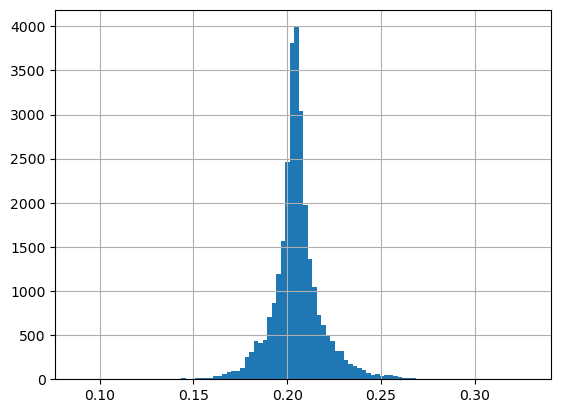

In [10]:
long_table= pd.read_csv('../final_data/US_long_table_28679.csv')
mean_matrix = pd.read_csv('../final_data/US_mean_matrix_241_241.csv')
long_table.Value.hist(bins = 100)

In [ ]:
# Check if the matrix is upper triangular
is_upper_triangular = np.allclose(mean_matrix.values, np.triu(mean_matrix.values))

# Print the result
print("Is the matrix upper triangular?", is_upper_triangular)
mean_matrix
# unique values and distribution
long_table.occ_i.nunique(), long_table.occ_j.nunique(), long_table.Value.hist(bins = 100)

In [ ]:
# .save("../figs_tabs/value_dist.png")
import pandas as pd
import matplotlib.pyplot as plt

# Assuming long_table is your DataFrame
# Compute the unique counts
occ_i_unique = long_table.occ_i.nunique()
occ_j_unique = long_table.occ_j.nunique()

# Plot and save the histogram for Value column
plt.figure(figsize=(10, 6))
plt.hist(long_table['Value'], bins=100, edgecolor='k')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
plt.savefig('../figs_tabs/US_value_dist.png')
plt.close()


print(f"Unique occ_i: {occ_i_unique}")
print(f"Unique occ_j: {occ_j_unique}")
print("Histogram saved as value_histogram.png")


In [ ]:
!ls -lha ../int_data/occ_space_chunks/occ_space_chunk* | wc -l

# Start (depcrecated)

In [ ]:
# %%time
# # 14.1 s for 2000 * 2000
# import numpy as np
# import pandas as pd

# # Number of unique i and j indices
# n = 20000

# # Generate random similarity values for the full matrix
# values = np.random.rand(n, n)

# # Create a DataFrame with all (i, j) pairs
# data = {
#     'i': np.repeat(np.arange(n), n),
#     'j': np.tile(np.arange(n), n),
#     'Value': values.flatten(),
#     'patent_id_i': [f'GB{np.random.randint(100000000, 999999999)}' for _ in range(n*n)],
#     'patent_id_j': [f'GB{np.random.randint(100000000, 999999999)}' for _ in range(n*n)]
# }

# df = pd.DataFrame(data)


In [ ]:
# %%time
# # Convert to NumPy array
# cosine_sim_long = df[['i', 'j', 'Value']].to_numpy()

In [ ]:
%%time
# Convert to NumPy array
cosine_sim_long = cosine_sim_long[['i', 'j', 'Value']].to_numpy()

In [ ]:
%%time

# Get the upper triangle (i < j)
upper = cosine_sim_long[cosine_sim_long[:, 0] < cosine_sim_long[:, 1]]

# Get the lower triangle (i > j)
lower = cosine_sim_long[cosine_sim_long[:, 0] > cosine_sim_long[:, 1]]

# Flip i and j in the lower triangle
lower_flipped = lower.copy()
lower_flipped[:, [0, 1]] = lower_flipped[:, [1, 0]]
print_ram_usage()

In [ ]:
%%time
# Combine the triangles
combined = np.concatenate((upper, lower_flipped), axis=0)

# Sum the values of the combined triangles by (i, j)
# Create a DataFrame for easier aggregation
combined_df = pd.DataFrame(combined, columns=['i', 'j', 'Value'])
print_ram_usage()


In [ ]:
upper.shape, lower.shape

In [ ]:
%%time

# Group by (i, j) and sum the 'Value' column
result_df = combined_df.groupby(['i', 'j'], as_index=False).sum()
print_ram_usage()
result_df

In [ ]:
print_ram_usage()


In [ ]:
# Combine the triangles
combined = np.vstack((upper, lower_flipped))

# Using NumPy to sum values for (i, j) pairs efficiently
ij = combined[:, :2].astype(int)
values = combined[:, 2]

# Create an empty matrix for the summed values
summed_values = np.zeros((n, n))

# Sum the values into the matrix
for k in range(combined.shape[0]):
    i, j = ij[k]
    summed_values[i, j] += values[k]

# Convert the matrix to a DataFrame if needed
result_df = pd.DataFrame(summed_values)

# Display the result
print(result_df)

In [ ]:
# import pickle

# with open('../int_data/result_df.pkl','wb') as f:
#     pickle.dump(result_df, f)

In [ ]:
import pickle

with open('../int_data/US_proxy/result_df.pkl','rb') as f:
    result_df = pickle.load(f)
    
result_df

In [ ]:
%%time
print_ram_usage()

result_df['patent_id_i'] = result_df['i'].apply(lambda x:tab_i[x])
print_ram_usage()

result_df['patent_id_j'] = result_df['j'].apply(lambda x:tab_j[x])
print_ram_usage()

# result_df = pd.merge(left = result_df, right = cosine_sim_long[['j', 'patent_id_j']], left_on = 'j', right_on = 'j')

In [ ]:
result_df.dtypes, type(result_df.Value.iloc[0])

In [ ]:
result_df.patent_id_i.isnull().sum(), result_df.patent_id_j.isnull().sum()

In [ ]:
# result_df.to_csv('../final_data/result_22120.csv', index = False)

# Aggregation on occupation

In [ ]:
import pandas as pd
# result_df = pd.read_csv('../final_data/result_22120.csv')
result_df = pd.read_feather('../final_data/result_29417.feather')

In [ ]:
result_df

In [ ]:
stopper

## Exploding Input_patent_matrix to get OCC_SPACE (unique non-na occs)

In [3]:
data = pd.read_csv('../int_data/Input_patent_matrix_US.csv')
data['strcount'] = data['description'].str.split().str.len()
# Filter the data based on the word count
# Too long or too short patents are filtered
data = data[(data['strcount'] > 10) & (data['strcount'] <= 500)].reset_index(drop = True)
data = data[['i', 'occupation.x']].rename(columns = {"occupation.x":"census_occupation"})

# str -> list
data_explode_pre = data
import re
# To split a string by both ", " and "; "

data_explode_pre.census_occupation = data_explode_pre.census_occupation.apply(lambda x: re.split(r', |; ', x.strip().strip(',')))
# data_explode_pre.census_occupation = data_explode_pre.census_occupation.apply(lambda x:x.strip().strip(',').split(', '))

KeyError: "['occupation.x'] not in index"

In [ ]:
data_explode_pre

In [ ]:
data_explode_pre.census_occupation[0][0]

In [ ]:
data_exploded = data_explode_pre.explode('census_occupation').reset_index(drop = True)
data_exploded

In [ ]:
data_exploded = data_exploded[data_exploded.census_occupation != 'NA'].reset_index(drop = True)
data_exploded

In [ ]:
# data_exploded.census_occupation.nunique(), data_exploded.i.nunique(), data_exploded.census_occupation.count_values()

In [ ]:
# All levels exploded?
data_exploded.len_census_occupation = data_exploded.census_occupation.apply(len)
data_exploded.len_census_occupation.value_counts()
# correct

## create dictionary for looking up

In [ ]:
# data_exploded.groupby('census_occupation').agg(lambda x:list(x))


## Aggregation

In [ ]:
data

In [ ]:
result_df

In [ ]:
# result_df_bak = result_df
# result_df = result_df_bak.head(10000000)
# result_df = result_df_bak

In [ ]:
%time
import numpy as np
import pandas as pd

# Step 1: Prepare necessary numpy arrays
value_array = result_df['Value'].values
patent_id_i_array = result_df['patent_id_i'].values
patent_id_j_array = result_df['patent_id_j'].values
census_occupation_array = data_exploded['census_occupation'].values
i_array = data_exploded['i'].values
print_ram_usage(1)

# Step 2: Merge result_df with data_exploded using numpy
def merge_with_numpy(value_array, patent_id_array, i_array, census_occupation_array):
    sort_idx = np.argsort(i_array)
    sorted_i = i_array[sort_idx]
    sorted_census_occupation = census_occupation_array[sort_idx]

    merged_values = []
    merged_census_occupations = []

    for patent_id, value in zip(patent_id_array, value_array):
        idx = np.searchsorted(sorted_i, patent_id)
        if idx < len(sorted_i) and sorted_i[idx] == patent_id:
            merged_values.append(value)
            merged_census_occupations.append(sorted_census_occupation[idx])

    return np.array(merged_values), np.array(merged_census_occupations)

values_i, census_occupations_i = merge_with_numpy(value_array, patent_id_i_array, i_array, census_occupation_array)
values_j, census_occupations_j = merge_with_numpy(value_array, patent_id_j_array, i_array, census_occupation_array)
print_ram_usage(2)

# Step 3: Combine results and drop NA
combined_values = np.concatenate([values_i, values_j])
combined_census_occupations = np.concatenate([census_occupations_i, census_occupations_j])

valid_idx = ~pd.isnull(combined_census_occupations)
combined_values = combined_values[valid_idx]
combined_census_occupations = combined_census_occupations[valid_idx]
print_ram_usage(3)

# Step 4: Group by census_occupation and compute the means using numpy
unique_occupations, inverse_idx = np.unique(combined_census_occupations, return_inverse=True)
sum_values = np.zeros(len(unique_occupations))
count_values = np.zeros(len(unique_occupations))
np.add.at(sum_values, inverse_idx, combined_values)
np.add.at(count_values, inverse_idx, 1)
mean_values = sum_values / count_values

aggregated_df = pd.DataFrame({'census_occupation': unique_occupations, 'Value': mean_values})
print_ram_usage(4)

# Step 5: Prepare pairwise combinations
occupations = data_exploded['census_occupation'].dropna().unique()
pairwise_combinations = pd.MultiIndex.from_product([occupations, occupations], names=['occupation_1', 'occupation_2']).to_frame(index=False)
pairwise_combinations = pairwise_combinations[pairwise_combinations.occupation_1 != pairwise_combinations.occupation_2]
print_ram_usage(5)

# Step 6: Merge pairwise_combinations with aggregated_df
aggregated_pairs = pd.merge(pairwise_combinations, aggregated_df, left_on='occupation_1', right_on='census_occupation', how='left').fillna(0)
aggregated_pairs = pd.merge(aggregated_pairs, aggregated_df, left_on='occupation_2', right_on='census_occupation', how='left').fillna(0)
print_ram_usage(6)

# Step 7: Calculate the combined value for each pair
aggregated_pairs['Combined_Value'] = (aggregated_pairs['Value_x'] + aggregated_pairs['Value_y']) / 2
print_ram_usage(7)

# Step 8: Drop intermediate columns
aggregated_pairs = aggregated_pairs[['occupation_1', 'occupation_2', 'Combined_Value']]
print_ram_usage(8)
aggregated_pairs

In [ ]:
combined_values, len(combined_values)

In [ ]:
combined_census_occupations, len(combined_census_occupations)

In [ ]:
aggregated_pairs.Combined_Value.value_counts()

In [ ]:
aggregated_pairs[aggregated_pairs.occupation_1 == aggregated_pairs.occupation_2]

In [ ]:
aggregated_pairs.to_feather('../final_data/agg_occ.feather')

In [ ]:
merged_df_j

In [ ]:
aggregated_pairs

In [ ]:
result_df_ij.len_patent_id_j_occ = result_df_ij.patent_id_j_occ.apply(len)
result_df_ij.len_patent_id_i_occ = result_df_ij.patent_id_i_occ.apply(len)
result_df_ij.len_patent_id_j_occ.value_counts(), result_df_ij.len_patent_id_i_occ.value_counts(), result_df_ij.patent_id_i.value_counts(), result_df_ij.patent_id_j.value_counts(), 

In [ ]:
aggregated_pairs

In [ ]:
result_df['patent_id_j_occ'] = pd.merge()

# merge

# find outer union of occs of id_i and id_j

# agg by occupations, and get (245 * 245 = ) 60,025 entries


In [ ]:
result_df = pd.merge(result_df, data_exploded, )

In [ ]:
# result_df.to_feather('../final_data/result_22120.feather')

In [ ]:
# TODO: aggregation on industry, occupation.y -> "census_occupation"
# Step 2:
# US census, patent data

In [ ]:
import pandas as pd
result_df = pd.read_feather('../final_data/result_22120.feather')

In [ ]:
result_df